##### about dataset
##### objective

# [ETL Pipeline](#etl_pipe)
# [Model Building](#model_building)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import warnings

In [2]:
pd.options.display.max_columns = 100
warnings.filterwarnings('ignore')

In [3]:
raw_data = pd.read_csv('hotel_bookings.csv')
raw_data.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,7/1/2015
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,7/1/2015
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,7/2/2015
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,7/2/2015
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,7/3/2015


##### We will consider booking without any adult irrelevant

In [4]:
data = raw_data[raw_data['adults']>0]

# Cleaning

In [5]:
((data.isnull().sum()
 /len(raw_data)*100)
 .pipe(lambda s: s[s>=50])
)

company    93.995309
dtype: float64

In [6]:
# Drop 'company' as 94% of values are missing

cols_to_drop = [] # we will place all unnecessary features in this list
cols_to_drop.append('company')
data = data.drop(['company'], axis=1)

In [7]:
# columns which we likely need to drop
drop_candidates = []

In [8]:
data.isna().sum()[data.isna().sum()>0]

children        4
country       478
agent       16263
dtype: int64

In [9]:
data['reservation_status_date'] = pd.to_datetime(data['reservation_status_date'])

In [10]:
data.dtypes.value_counts()

int64             16
object            11
float64            3
datetime64[ns]     1
Name: count, dtype: int64

In [11]:
object_cols = data.select_dtypes('object').columns
list(object_cols)

['hotel',
 'arrival_date_month',
 'meal',
 'country',
 'market_segment',
 'distribution_channel',
 'reserved_room_type',
 'assigned_room_type',
 'deposit_type',
 'customer_type',
 'reservation_status']

In [12]:
# checking correctness of values in categorical features

for col in object_cols:
    print('Feature {} contains values {}'.format(col, data[col].unique()))
    print()

Feature hotel contains values ['Resort Hotel' 'City Hotel']

Feature arrival_date_month contains values ['July' 'August' 'September' 'October' 'November' 'December' 'January'
 'February' 'March' 'April' 'May' 'June']

Feature meal contains values ['BB' 'FB' 'HB' 'SC' 'Undefined']

Feature country contains values ['PRT' 'GBR' 'USA' 'ESP' 'IRL' 'FRA' nan 'ROU' 'NOR' 'OMN' 'ARG' 'POL'
 'DEU' 'BEL' 'CHE' 'CN' 'GRC' 'ITA' 'NLD' 'DNK' 'RUS' 'SWE' 'AUS' 'EST'
 'CZE' 'BRA' 'FIN' 'MOZ' 'BWA' 'LUX' 'SVN' 'ALB' 'IND' 'CHN' 'MEX' 'MAR'
 'UKR' 'SMR' 'LVA' 'PRI' 'SRB' 'CHL' 'AUT' 'BLR' 'LTU' 'TUR' 'ZAF' 'AGO'
 'ISR' 'CYM' 'ZMB' 'CPV' 'ZWE' 'DZA' 'KOR' 'CRI' 'HUN' 'ARE' 'TUN' 'JAM'
 'HRV' 'HKG' 'IRN' 'GEO' 'AND' 'GIB' 'URY' 'JEY' 'CAF' 'CYP' 'COL' 'GGY'
 'KWT' 'NGA' 'MDV' 'VEN' 'SVK' 'FJI' 'KAZ' 'PAK' 'IDN' 'LBN' 'PHL' 'SEN'
 'SYC' 'AZE' 'BHR' 'NZL' 'THA' 'DOM' 'MKD' 'MYS' 'ARM' 'JPN' 'LKA' 'CUB'
 'CMR' 'BIH' 'MUS' 'COM' 'SUR' 'UGA' 'BGR' 'CIV' 'JOR' 'SYR' 'SGP' 'BDI'
 'SAU' 'VNM' 'PLW' 'QAT' 'EGY' '

##### Our data doesn`t contain any obvious dirtiness. We only have to deal with 3 features containing missing values 

In [13]:
data['children'].value_counts()

children
0.0     110616
1.0       4857
2.0       3444
3.0         65
10.0         1
Name: count, dtype: int64

In [14]:
data['children'].fillna(0, inplace=True)

In [15]:
data['country'].value_counts() 

country
PRT    48440
GBR    12105
FRA    10376
ESP     8546
DEU     7271
       ...  
DJI        1
BWA        1
HND        1
VGB        1
NAM        1
Name: count, Length: 177, dtype: int64

##### random impute: we will fill missing values with randomly sampled values of feature

In [16]:
sample = data['country'].dropna().sample(data['country'].isna().sum())
sample

99421     FRA
93842     PRT
73662     BEL
37384     GBR
117371    GBR
         ... 
107127    ESP
115109    DEU
23223     GBR
10309     ESP
12935     ESP
Name: country, Length: 478, dtype: object

In [17]:
sample.index = data[data['country'].isna()].index

In [18]:
data.loc[data['country'].isna(), 'country'] = sample

##### create function to automate this approach

In [19]:
def RandomImpute(df, feature):
    random_sample = df[feature].dropna().sample(df[feature].isna().sum())
    random_sample.index = df[df[feature].isna()].index
    df.loc[df[feature].isna(), feature] = random_sample

In [20]:
data['agent'].value_counts()

agent
9.0      31743
240.0    13922
1.0       7187
14.0      3617
7.0       3528
         ...  
289.0        1
432.0        1
265.0        1
93.0         1
304.0        1
Name: count, Length: 333, dtype: int64

In [21]:
RandomImpute(data, 'agent')

In [22]:
data.isna().sum()

hotel                             0
is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
meal                              0
country                           0
market_segment                    0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
assigned_room_type                0
booking_changes                   0
deposit_type                      0
agent                             0
days_in_waiting_list              0
customer_type                     0
adr                               0
required_car_parking_spaces 

##### now we have a clean dataset

# Data Analysis (EDA)

In [23]:
# setting runtime configurtion
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 13
plt.rcParams['xtick.labelsize'] = 11
plt.rcParams['ytick.labelsize'] = 11

### Top countries where the guests come from

In [24]:
data_canceled0 = data.query("is_canceled==0")

In [25]:
country_data = (data_canceled0
 .groupby(['hotel', 'country']).size()
 .reset_index()
 .rename(columns={0:'no_guests'})
)

In [26]:
country_data

,hotel,country,no_guests
0,City Hotel,ABW,2
1,City Hotel,AGO,140
2,City Hotel,AIA,1
3,City Hotel,ALB,8
4,City Hotel,ARE,5
...,...,...,...
264,Resort Hotel,VEN,2
265,Resort Hotel,VNM,2
266,Resort Hotel,ZAF,13
267,Resort Hotel,ZMB,1


In [27]:
def top_n_items(sub_df, n, sort_col):
    return sub_df.nlargest(n, sort_col)

In [28]:
country_data = country_data.groupby('hotel').apply(top_n_items, n=10, sort_col='no_guests')

In [29]:
country_data = country_data.reset_index(level=0, drop=True)

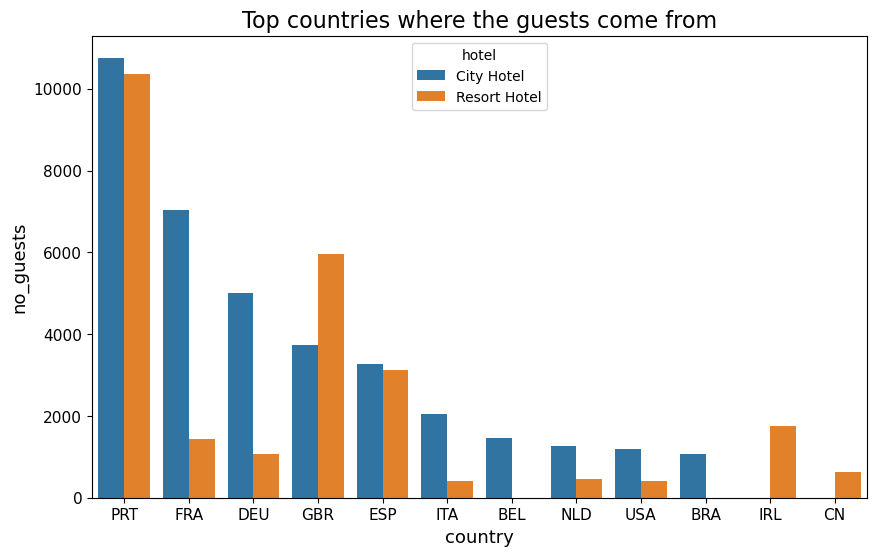

In [30]:
plt.figure(figsize = (10,6))
sns.barplot(data = country_data, x = 'country', y = 'no_guests', hue='hotel')
plt.title('Top countries where the guests come from')
plt.show()

### Do guests come with children/babies?

In [31]:
children = data_canceled0[['children', 'babies', 'hotel']]

In [32]:
children['with_children'] = (children['children']>0)|(children['babies']>0)

In [33]:
children['with_children'] = children['with_children'].map({False:'no', True:'yes'})

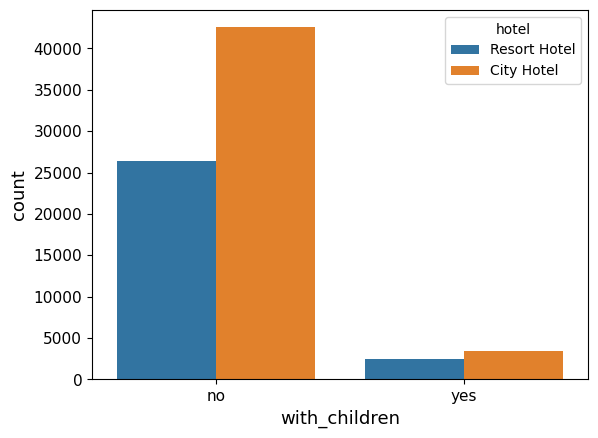

In [34]:
sns.countplot(data = children, x = 'with_children', hue='hotel')
plt.show()

### How much do guests pay for a room per night?

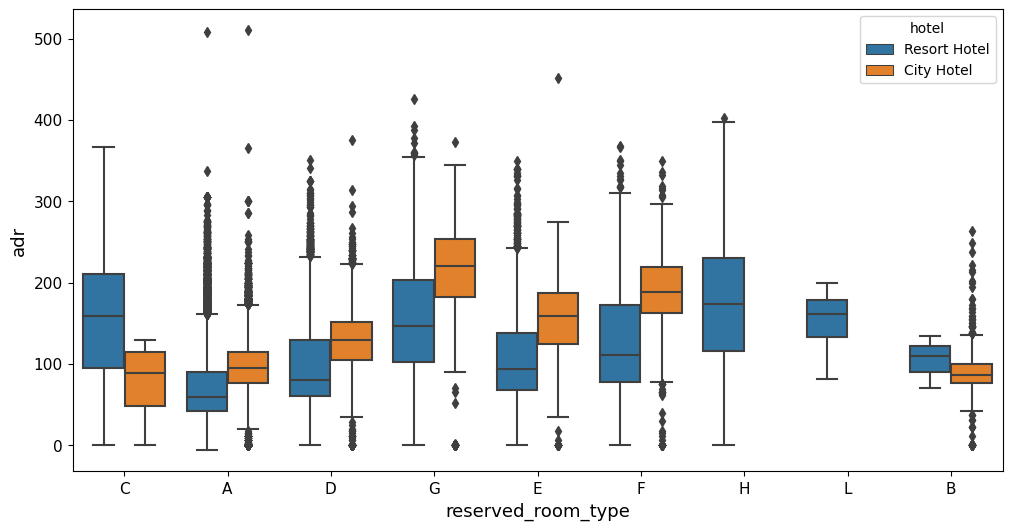

In [35]:
plt.figure(figsize=(12,6))
sns.boxplot(data = data_canceled0, x = 'reserved_room_type', y = 'adr', hue = 'hotel')
plt.show()

### Bookings made for weekdays weekends or both?

In [36]:
data_canceled0.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,9.0,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,9.0,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,240.0,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [37]:
def stays_func(row):
    
    feature1 = 'stays_in_weekend_nights'
    feature2 = 'stays_in_week_nights'
    
    if (row[feature1] > 0)&(row[feature2] == 0):
        return 'just_weekend'
    if (row[feature1] == 0)&(row[feature2] > 0):
        return 'just_week'
    if (row[feature1] > 0)&(row[feature2] > 0):
        return 'both_weekend_and_week'
    else:
        return 'undefined'

In [38]:
data_canceled0['stays'] = data_canceled0.apply(stays_func,axis=1)

In [39]:
resort_data = data_canceled0.query("hotel=='Resort Hotel'")
city_data = data_canceled0.query("hotel=='City Hotel'")

In [40]:
resort_data.groupby(['arrival_date_month', 'stays']).size().unstack()

stays,both_weekend_and_week,just_week,just_weekend,undefined
arrival_date_month,,,,
April,1495,898,137,20
August,2309,744,170,34
December,808,1007,147,52
February,1002,1089,197,20
January,649,990,196,31
July,2188,777,132,40
June,1337,592,82,26
March,1162,1227,154,28
May,1450,826,221,38


In [41]:
# let us sort the obtained dataframe by month

import sort_dataframeby_monthorweek as sd

In [42]:
grouped_resort = resort_data.groupby(['arrival_date_month', 'stays']).size().unstack().reset_index()

In [43]:
grouped_resort = sd.Sort_Dataframeby_Month(grouped_resort,'arrival_date_month')

In [44]:
grouped_resort = grouped_resort.set_index('arrival_date_month')

In [45]:
grouped_resort

,both_weekend_and_week,just_week,just_weekend,undefined
arrival_date_month,,,,
January,649,990,196,31
February,1002,1089,197,20
March,1162,1227,154,28
April,1495,898,137,20
May,1450,826,221,38
June,1337,592,82,26
July,2188,777,132,40
August,2309,744,170,34
September,1457,554,83,8


In [46]:
# the same procedure for City Hotel
grouped_city = city_data.groupby(['arrival_date_month', 'stays']).size().unstack().reset_index()
grouped_city = sd.Sort_Dataframeby_Month(grouped_city,'arrival_date_month')
grouped_city = grouped_city.set_index('arrival_date_month')

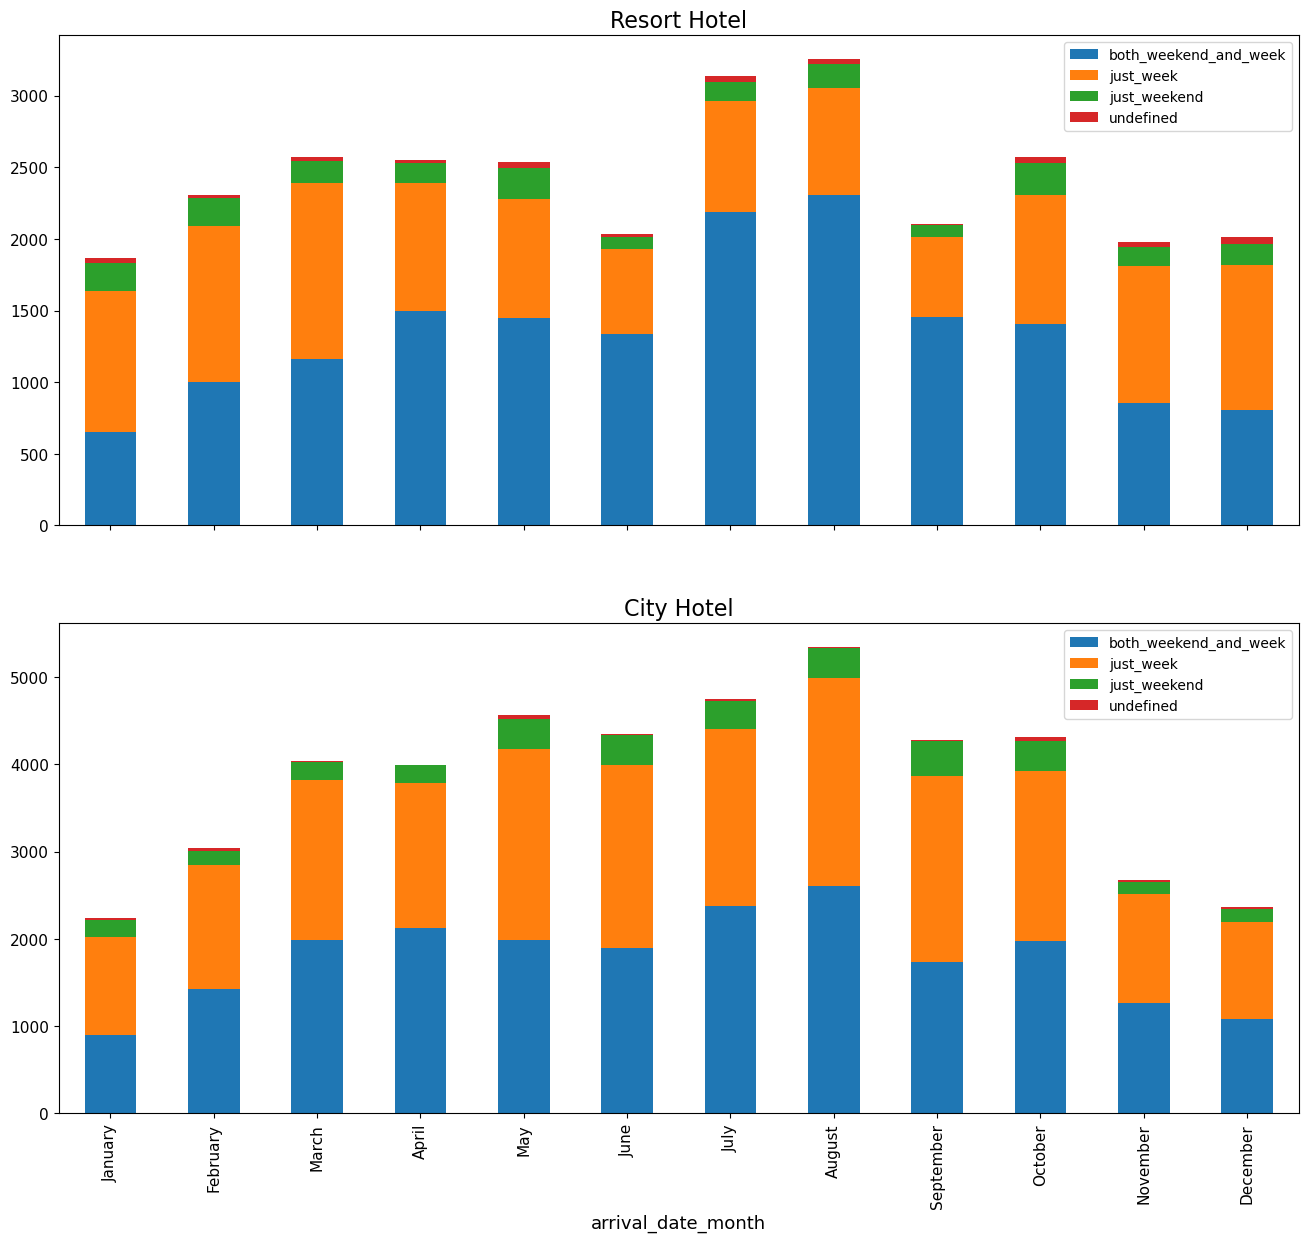

In [47]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16,14), sharex = True)
grouped_resort.plot(kind='bar', stacked=True, ax=ax1)
grouped_city.plot(kind='bar', stacked=True, ax=ax2)
ax1.set_title('Resort Hotel')
ax2.set_title('City Hotel')
plt.show()

### Which are the most busy months?

In [48]:
data_canceled0.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,stays
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,9.0,0,Transient,0.0,0,0,Check-Out,2015-07-01,undefined
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,9.0,0,Transient,0.0,0,0,Check-Out,2015-07-01,undefined
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,240.0,0,Transient,75.0,0,0,Check-Out,2015-07-02,just_week
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,0,Transient,75.0,0,0,Check-Out,2015-07-02,just_week
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,0,Transient,98.0,0,1,Check-Out,2015-07-03,just_week


In [49]:
month_resort = resort_data['arrival_date_month'].value_counts().reset_index()
month_resort.columns = ['month', 'no_bookings_resort']
month_city = city_data['arrival_date_month'].value_counts().reset_index()
month_city.columns = ['month', 'no_bookings_city']

In [50]:
month_data = month_resort.merge(month_city, on = 'month')
month_data = sd.Sort_Dataframeby_Month(month_data, 'month')

In [51]:
month_data

,month,no_bookings_resort,no_bookings_city
0,January,1866,2235
1,February,2308,3039
2,March,2571,4043
3,April,2550,3997
4,May,2535,4560
5,June,2037,4349
6,July,3137,4747
7,August,3257,5346
8,September,2102,4279
9,October,2575,4312


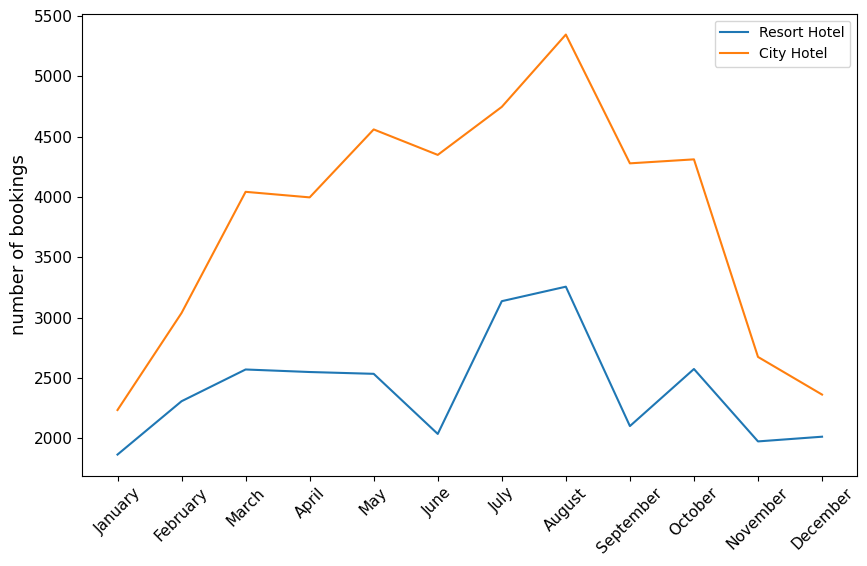

In [52]:
plt.figure(figsize=(10,6))
plt.plot(month_data['month'], month_data['no_bookings_resort'], label='Resort Hotel')
plt.plot(month_data['month'], month_data['no_bookings_city'], label='City Hotel')
plt.ylabel('number of bookings')
plt.xticks(rotation = 45)
plt.legend()
plt.show()

In [ ]:
#change

### Which month has highest adr?

In [53]:
data_canceled0_sorted = sd.Sort_Dataframeby_Month(data_canceled0, 'arrival_date_month')

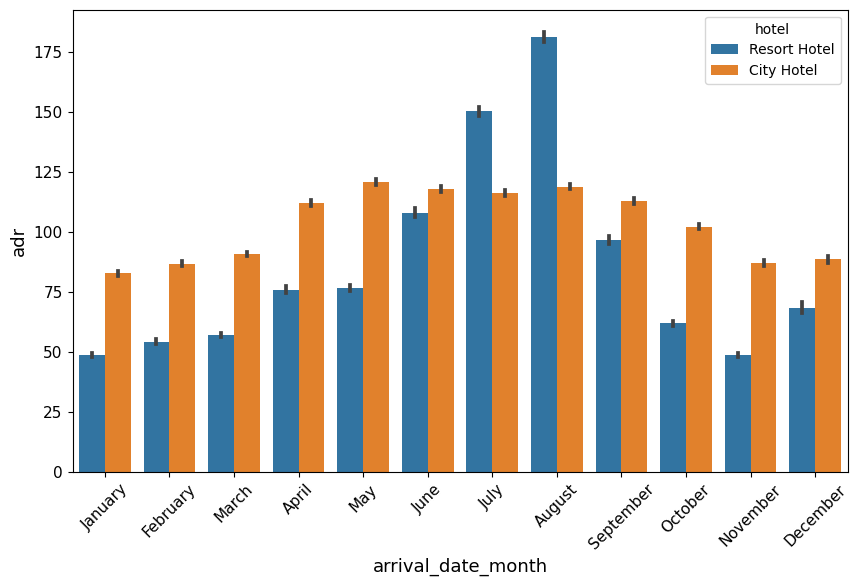

In [54]:
plt.figure(figsize=(10,6))
sns.barplot(data = data_canceled0_sorted, x = 'arrival_date_month', y = 'adr', hue = 'hotel')
plt.xticks(rotation=45)
plt.show()

# Feature Engineering

In [55]:
data.dtypes.value_counts()

int64             16
object            11
float64            3
datetime64[ns]     1
Name: count, dtype: int64

In [56]:
data.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,9.0,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,9.0,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,240.0,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [57]:
# create lists for new features and for features which were used in forming these new features
added_cols = []
forming_cols = []

In [58]:
data['total_nights'] = data['stays_in_weekend_nights'] + data['stays_in_week_nights']

added_cols.append('total_nights')
forming_cols.append('stays_in_weekend_nights')
drop_candidates.append('stays_in_weekend_nights')
forming_cols.append('stays_in_week_nights')
drop_candidates.append('stays_in_week_nights')

In [59]:
def stays_func(row):
    
    feature1 = 'stays_in_weekend_nights'
    feature2 = 'stays_in_week_nights'
    
    if (row[feature1] > 0)&(row[feature2] == 0):
        return 'just_weekend'
    if (row[feature1] == 0)&(row[feature2] > 0):
        return 'just_week'
    if (row[feature1] > 0)&(row[feature2] > 0):
        return 'both_weekend_and_week'
    else:
        return 'undefined'

In [60]:
data['stays_format'] = data.apply(stays_func, axis=1)

added_cols.append('stays_format')

In [61]:
data['total_guests'] = data['adults']+data['children']+data['babies']

added_cols.append('total_guests')
forming_cols.append('adults')
forming_cols.append('children')
forming_cols.append('babies')
drop_candidates.append('adults')
drop_candidates.append('children')
drop_candidates.append('babies')

In [62]:
def children_func(row):
    if (row['children'] == 0)&(row['babies'] == 0):
        return 0
    else:
        return 1

In [63]:
data['children_binary'] = data.apply(children_func, axis = 1)

added_cols.append('children_binary')

In [64]:
def room_type(row):
    if row['assigned_room_type'] == row['reserved_room_type']:
        return 1
    else:
        return 0

In [65]:
data['room_assigned_equal_reserved'] = data.apply(room_type, axis = 1)

added_cols.append('room_assigned_equal_reserved')
forming_cols.append('assigned_room_type')
forming_cols.append('reserved_room_type')
drop_candidates.append('assigned_room_type')
drop_candidates.append('reserved_room_type')

In [66]:
def deposit_type(row):
    if row['deposit_type'] == 'Non Refund':
        return 1
    else:
        return 0

In [67]:
data['deposit_type'] = data.apply(deposit_type, axis=1)

added_cols.append('deposit_type')
forming_cols.append('deposit_type')

In [68]:
# represents the same info as feature is_canceled

data.drop(['reservation_status'], axis=1, inplace=True)
cols_to_drop.append('reservation_status')

In [69]:
data.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status_date,total_nights,stays_format,total_guests,children_binary,room_assigned_equal_reserved
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,0,9.0,0,Transient,0.0,0,0,2015-07-01,0,undefined,2.0,0,1
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,0,9.0,0,Transient,0.0,0,0,2015-07-01,0,undefined,2.0,0,1
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,0,240.0,0,Transient,75.0,0,0,2015-07-02,1,just_week,1.0,0,0
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,0,304.0,0,Transient,75.0,0,0,2015-07-02,1,just_week,1.0,0,1
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,0,240.0,0,Transient,98.0,0,1,2015-07-03,2,just_week,2.0,0,1


### adr seasonal decomposition

It is logical to assume that average daily rate would probably have seasonal pattern. The information we extract from this feature could be of an importance further. 

#### Encoding arrival_date_month

In [70]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [71]:
import sort_dataframeby_monthorweek as sd

In [72]:
months = sd.Sort_Dataframeby_Month(data,'arrival_date_month')['arrival_date_month'].unique()

In [73]:
month_encoding = np.arange(1,13)

In [74]:
enc_dict = {}
for obj in zip(months, month_encoding):
    enc_dict[obj[0]] = obj[1]

In [75]:
data['arrival_date_month'] = data['arrival_date_month'].map(enc_dict)

#### Let us make seasonal decomposition in detail for the part of dataset which represents Resort Hotel only

In [76]:
resort_data = data.query("hotel == 'Resort Hotel'").reset_index()
resort_data.head()

,index,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status_date,total_nights,stays_format,total_guests,children_binary,room_assigned_equal_reserved
0,0,Resort Hotel,0,342,2015,7,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,0,9.0,0,Transient,0.0,0,0,2015-07-01,0,undefined,2.0,0,1
1,1,Resort Hotel,0,737,2015,7,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,0,9.0,0,Transient,0.0,0,0,2015-07-01,0,undefined,2.0,0,1
2,2,Resort Hotel,0,7,2015,7,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,0,240.0,0,Transient,75.0,0,0,2015-07-02,1,just_week,1.0,0,0
3,3,Resort Hotel,0,13,2015,7,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,0,304.0,0,Transient,75.0,0,0,2015-07-02,1,just_week,1.0,0,1
4,4,Resort Hotel,0,14,2015,7,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,0,240.0,0,Transient,98.0,0,1,2015-07-03,2,just_week,2.0,0,1


In [77]:
grouped_resort = resort_data.groupby(['arrival_date_year', 'arrival_date_month'])['adr'].median()
grouped_resort

arrival_date_year  arrival_date_month
2015               7                     123.00
                   8                     154.00
                   9                      79.50
                   10                     51.00
                   11                     41.44
                   12                     55.00
2016               1                      44.80
                   2                      53.00
                   3                      53.57
                   4                      68.00
                   5                      68.00
                   6                      94.37
                   7                     159.00
                   8                     197.10
                   9                      92.00
                   10                     61.00
                   11                     47.00
                   12                     60.60
2017               1                      48.00
                   2                      49.00
  

In [78]:
# as we obtained monthly data 
decomposition_resort = seasonal_decompose(grouped_resort, model='additive', period=12, extrapolate_trend='freq')

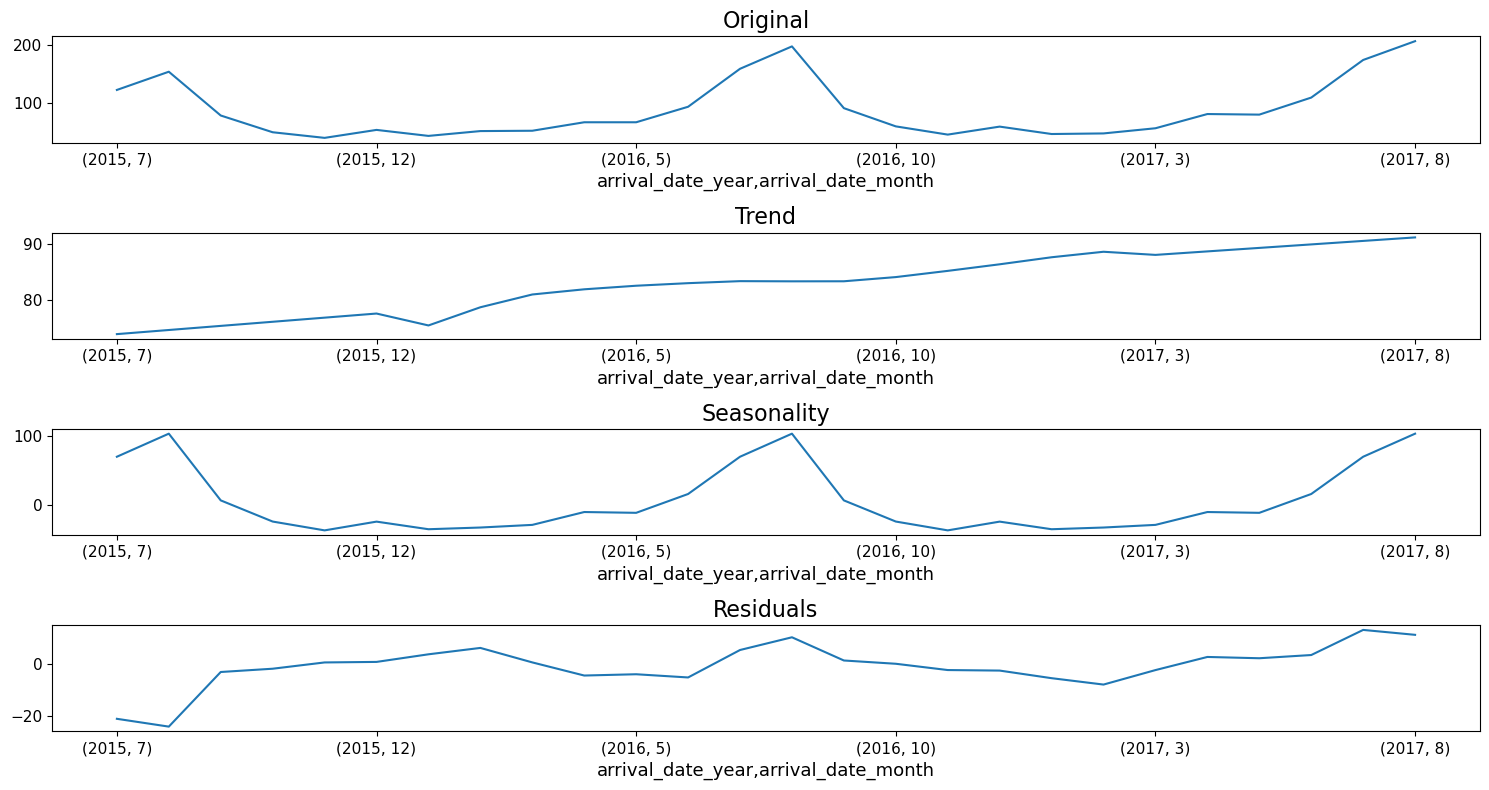

In [79]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 8))
grouped_resort.plot(ax=ax1, title='Original')
decomposition_resort.trend.plot(ax=ax2, title='Trend')
decomposition_resort.seasonal.plot(ax=ax3, title='Seasonality')
decomposition_resort.resid.plot(ax=ax4, title='Residuals')
fig.tight_layout()

In [80]:
seasonal_resort = (pd.DataFrame(grouped_resort).assign(trend = decomposition_resort.trend.values,
                                    seasonality = decomposition_resort.seasonal.values,
                                    resid = decomposition_resort.resid.values)
                 .drop(['adr'], axis=1).reset_index())

In [81]:
(pd.merge(resort_data, seasonal_resort, on=['arrival_date_year', 'arrival_date_month'])
 .set_index('index')
)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status_date,total_nights,stays_format,total_guests,children_binary,room_assigned_equal_reserved,trend,seasonality,resid
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,Resort Hotel,0,342,2015,7,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,0,9.0,0,Transient,0.00,0,0,2015-07-01,0,undefined,2.0,0,1,73.733977,70.171335,-20.905312
1,Resort Hotel,0,737,2015,7,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,0,9.0,0,Transient,0.00,0,0,2015-07-01,0,undefined,2.0,0,1,73.733977,70.171335,-20.905312
2,Resort Hotel,0,7,2015,7,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,0,240.0,0,Transient,75.00,0,0,2015-07-02,1,just_week,1.0,0,0,73.733977,70.171335,-20.905312
3,Resort Hotel,0,13,2015,7,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,0,304.0,0,Transient,75.00,0,0,2015-07-02,1,just_week,1.0,0,1,73.733977,70.171335,-20.905312
4,Resort Hotel,0,14,2015,7,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,0,240.0,0,Transient,98.00,0,1,2015-07-03,2,just_week,2.0,0,1,73.733977,70.171335,-20.905312
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40055,Resort Hotel,0,212,2017,8,35,31,2,8,2,1.0,0,BB,GBR,Offline TA/TO,TA/TO,0,0,0,A,A,1,0,143.0,0,Transient,89.75,0,0,2017-09-10,10,both_weekend_and_week,3.0,1,1,91.262532,103.422588,11.314881
40056,Resort Hotel,0,169,2017,8,35,30,2,9,2,0.0,0,BB,IRL,Direct,Direct,0,0,0,E,E,0,0,250.0,0,Transient-Party,202.27,0,1,2017-09-10,11,both_weekend_and_week,2.0,0,1,91.262532,103.422588,11.314881
40057,Resort Hotel,0,204,2017,8,35,29,4,10,2,0.0,0,BB,IRL,Direct,Direct,0,0,0,E,E,0,0,250.0,0,Transient,153.57,0,3,2017-09-12,14,both_weekend_and_week,2.0,0,1,91.262532,103.422588,11.314881


#### as a result we added information about trend seasonality and residuals at the end of the dataset

#### lets automate

In [82]:
def get_seasonal(group, time_col, agg_col, period):
    
    # group by time_col and use mean as aggregation function
    group = group.reset_index()
    ts = group.groupby(time_col)[agg_col].median()

    # Handle groups with insufficient data
    if len(ts) < period+1:
        return group.assign(seasonal=0, trend=0, resid=0).set_index('index')

    # Decompose the time series
    res = seasonal_decompose(ts, model='additive', period=period, extrapolate_trend='freq')
    
    # Attaching decomposed components to the ts
    components = (pd.DataFrame(ts).assign(trend = res.trend.values,
                                    seasonal = res.seasonal.values,
                                    resid = res.resid.values)
                                  .drop([agg_col], axis=1).reset_index())
    
    # merging group and components on time_col
    return pd.merge(group, components, on=time_col).set_index('index')

def add_seasonal(df, time_col, group_cols, agg_col):
    return (df
            .groupby(group_cols)
            .apply(get_seasonal, time_col=time_col, agg_col=agg_col, period=12)
            .drop(columns=group_cols)
            .reset_index(drop=False)
            .set_index('index')
            .loc[df.index]
    )

In [83]:
data = add_seasonal(data, ['arrival_date_year', 'arrival_date_month'], 'hotel', agg_col='adr')
data.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status_date,total_nights,stays_format,total_guests,children_binary,room_assigned_equal_reserved,trend,seasonal,resid
0,Resort Hotel,0,342,2015,7,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,0,9.0,0,Transient,0.0,0,0,2015-07-01,0,undefined,2.0,0,1,73.733977,70.171335,-20.905312
1,Resort Hotel,0,737,2015,7,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,0,9.0,0,Transient,0.0,0,0,2015-07-01,0,undefined,2.0,0,1,73.733977,70.171335,-20.905312
2,Resort Hotel,0,7,2015,7,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,0,240.0,0,Transient,75.0,0,0,2015-07-02,1,just_week,1.0,0,0,73.733977,70.171335,-20.905312
3,Resort Hotel,0,13,2015,7,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,0,304.0,0,Transient,75.0,0,0,2015-07-02,1,just_week,1.0,0,1,73.733977,70.171335,-20.905312
4,Resort Hotel,0,14,2015,7,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,0,240.0,0,Transient,98.0,0,1,2015-07-03,2,just_week,2.0,0,1,73.733977,70.171335,-20.905312


In [84]:
added_cols.append('trend')
added_cols.append('seasonal')
added_cols.append('resid')

In [85]:
forming_cols.append('hotel')
forming_cols.append('adr')
forming_cols.append('arrival_date_year')
forming_cols.append('arrival_date_month')

### Feature Encoding

In [86]:
cat_cols = data.select_dtypes('object').columns
num_cols = data.select_dtypes(exclude=['object', 'datetime64[ns]']).columns

In [87]:
data[cat_cols].nunique()

hotel                     2
meal                      5
country                 177
market_segment            8
distribution_channel      5
reserved_room_type        9
assigned_room_type       11
customer_type             4
stays_format              4
dtype: int64

In [88]:
high_cardinality_feats = data[cat_cols].nunique().pipe(lambda s: s[s>=5]).index
low_cardinality_feats = cat_cols.difference(high_cardinality_feats)

In [89]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import TargetEncoder
from sklearn import set_config

In [90]:
set_config(transform_output='pandas')

In [91]:
l_enc = LabelEncoder()

In [92]:
for col in low_cardinality_feats:
    data[col] = l_enc.fit_transform(data[col])

In [93]:
t_enc = TargetEncoder(target_type='binary', random_state=123)

In [94]:
data[high_cardinality_feats] = t_enc.fit_transform(data[high_cardinality_feats], data['is_canceled'])

In [95]:
data[cat_cols].head()

,hotel,meal,country,market_segment,distribution_channel,reserved_room_type,assigned_room_type,customer_type,stays_format
0,1,0.374473,0.564958,0.151095,0.173178,0.326231,0.184386,2,3
1,1,0.373804,0.566940,0.155790,0.176098,0.328803,0.187333,2,3
2,1,0.373798,0.201373,0.153950,0.175122,0.391693,0.192612,2,1
3,1,0.374473,0.201432,0.188650,0.223141,0.391085,0.444683,2,1
4,1,0.374151,0.201622,0.368152,0.410818,0.391783,0.445669,2,1


# Handling outliers (log-transform & binarization)

In [96]:
len(num_cols)

28

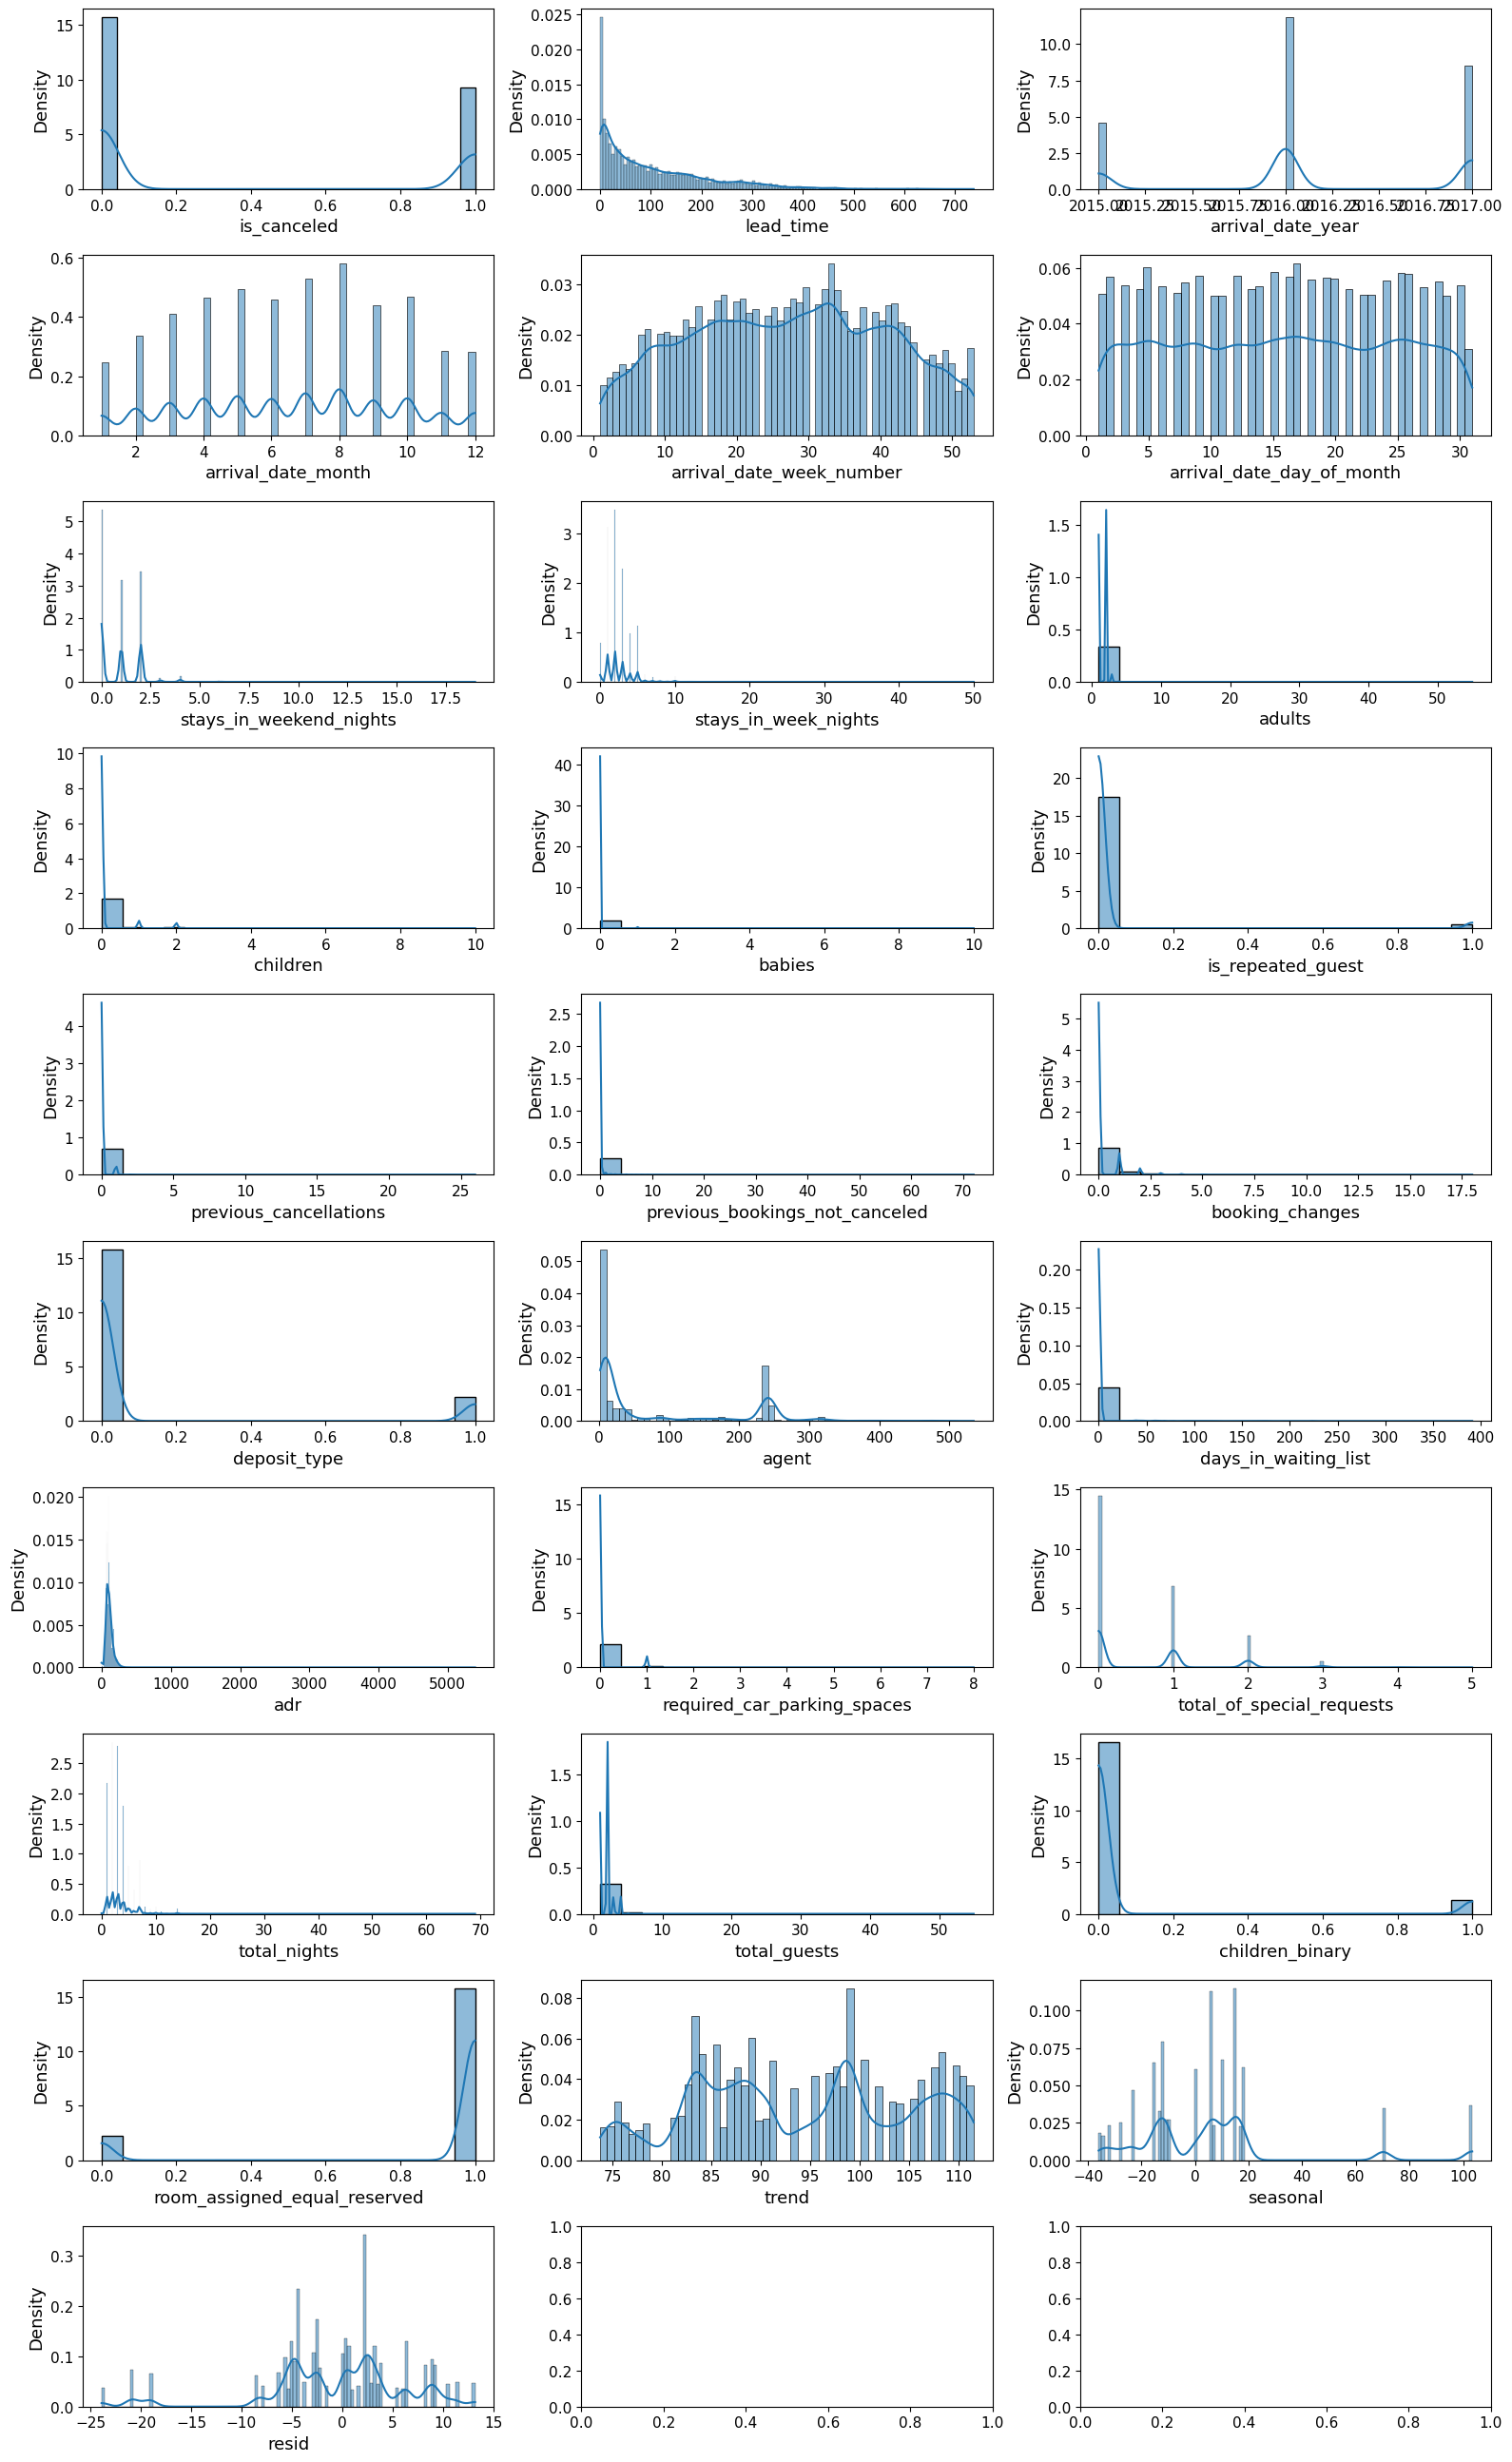

In [97]:
fig, ax = plt.subplots(10,3, figsize = (16,26))

for i, col in enumerate(num_cols):
    sns.histplot(data = data, x = col, ax = ax[i//3, i%3], stat='density', kde=True)

fig.tight_layout()

In [98]:
drop_candidates.extend(['arrival_date_year', 'arrival_date_month', 'arrival_date_week_number', 
                        'arrival_date_day_of_month', 'reservation_status_date'])

#### continious features

In [99]:
def hist_and_box(col):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (8,6))
    sns.boxplot(data[col], ax = ax1, orient = 'h')
    sns.histplot(data[col], stat='density', kde = True, ax = ax2)
    ax1.set_xticks([])
    ax1.set_yticks([])
    fig.tight_layout()
    plt.show()

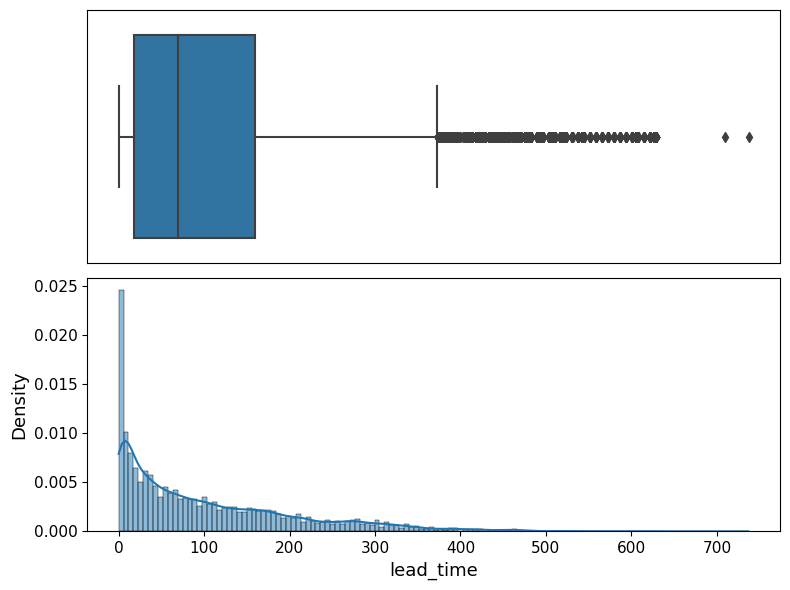

In [100]:
hist_and_box('lead_time')

In [101]:
def log_transform(col):
    data[col] = np.log1p(data[col])

In [102]:
log_transform('lead_time')

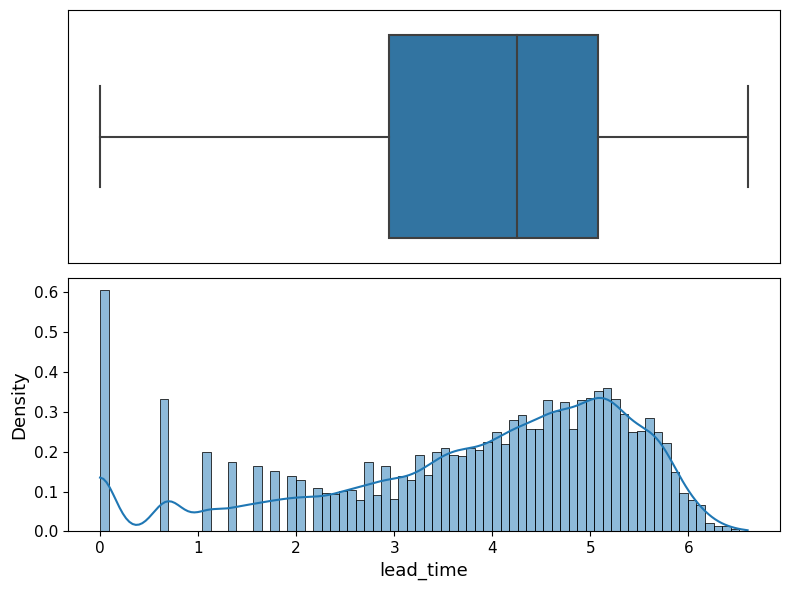

In [103]:
hist_and_box('lead_time')

adr

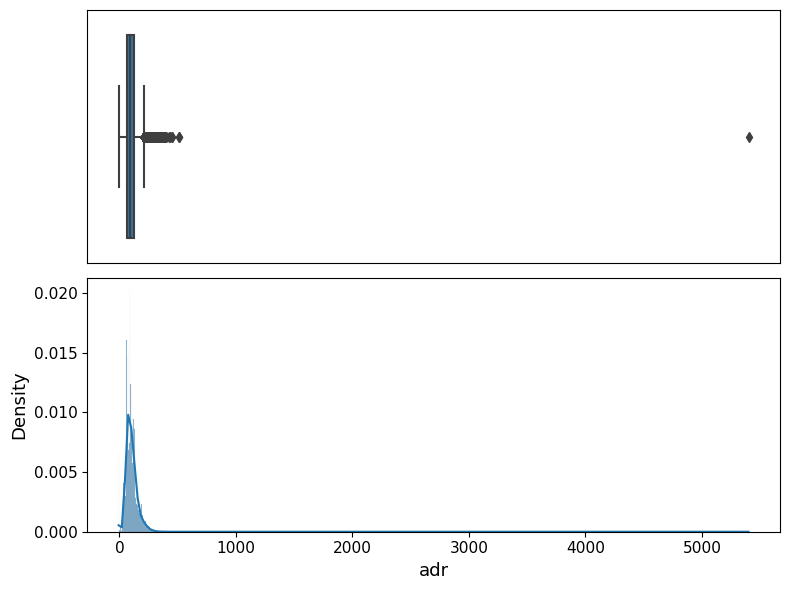

In [104]:
hist_and_box('adr')

In [105]:
(data['adr'] < 0).sum()

1

#### one of instances has negative adr

In [106]:
log_transform('adr')

In [107]:
data.adr.isna().sum()

1

In [108]:
data['adr'] = data['adr'].fillna(0)

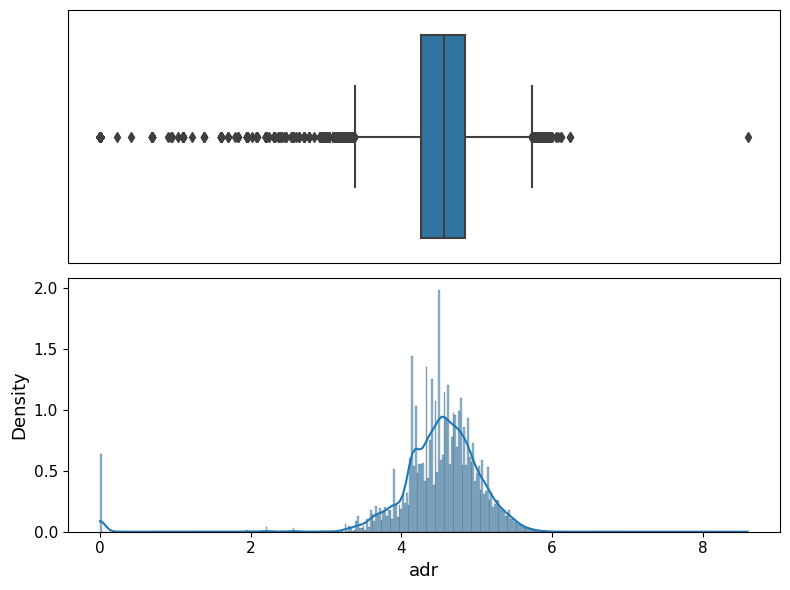

In [109]:
hist_and_box('adr')

#### discrete features

In [110]:
drop_candidates

['stays_in_weekend_nights',
 'stays_in_week_nights',
 'adults',
 'children',
 'babies',
 'assigned_room_type',
 'reserved_room_type',
 'arrival_date_year',
 'arrival_date_month',
 'arrival_date_week_number',
 'arrival_date_day_of_month',
 'reservation_status_date']

In [111]:
data['total_guests'].value_counts().sort_index()

total_guests
1.0     22577
2.0     81846
3.0     10481
4.0      3929
5.0       137
6.0         1
10.0        2
12.0        2
20.0        2
26.0        5
27.0        2
40.0        1
50.0        1
55.0        1
Name: count, dtype: int64

In [112]:
data['total_guests'] = np.where(data['total_guests']>=4, 4, data['total_guests'])

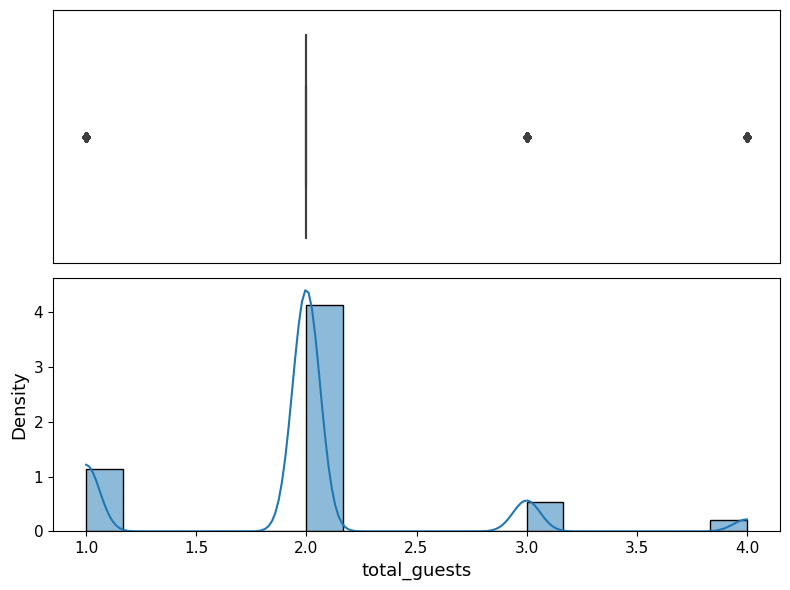

In [113]:
hist_and_box('total_guests')

In [114]:
# automate
def outlier_func(col, val):
    data[col] = np.where(data[col]>=val, val, data[col])

In [115]:
outlier_func('previous_cancellations', 1)

In [116]:
outlier_func('previous_bookings_not_canceled', 1)

In [117]:
outlier_func('booking_changes', 1)

In [118]:
outlier_func('days_in_waiting_list', 1)

In [119]:
outlier_func('required_car_parking_spaces', 1)

In [120]:
outlier_func('total_of_special_requests', 2)

In [121]:
outlier_func('total_nights', 8)

# Filtering Features (corr matrix & univariate analysis)

In [122]:
final_data = data.drop(drop_candidates, axis=1)
len(final_data.columns)

26

#### Let's find out in which columns a single value predominates

In [123]:
value_list = []
perc_list = []
for col in final_data.columns:
    counts = final_data[col].value_counts()/len(final_data)*100
    value_list.append(counts.index[0])
    perc_list.append(counts.max())

share_df = (pd.DataFrame({'value': value_list, 'percentage': perc_list}, index=final_data.columns)
           .sort_values(by='percentage', ascending=False))

cols_with_single = share_df[share_df['percentage']>=90].index

In [124]:
share_df.loc[cols_with_single,:]

,value,percentage
previous_bookings_not_canceled,0.0,96.964374
days_in_waiting_list,0.0,96.896300
is_repeated_guest,0.0,96.845033
previous_cancellations,0.0,94.556548
required_car_parking_spaces,0.0,93.774950
children_binary,0.0,92.344542


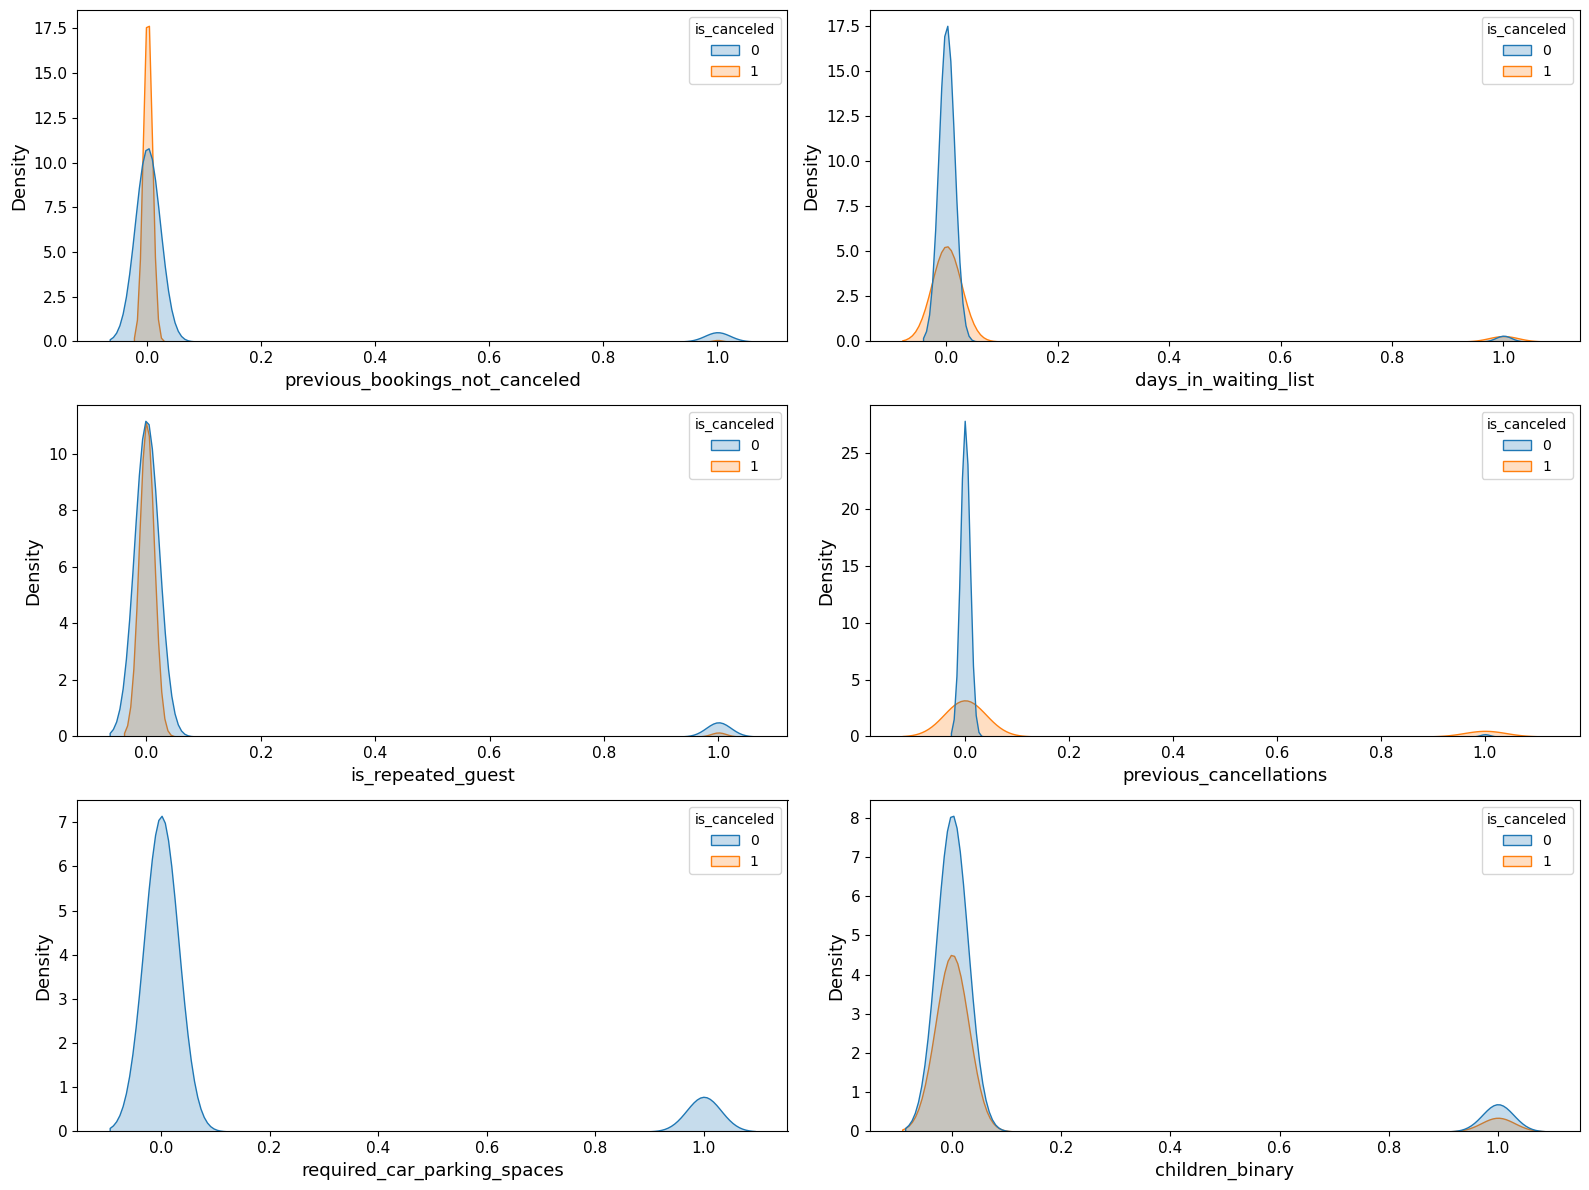

In [125]:
fig, ax = plt.subplots(figsize=(16,12))
for i, col in enumerate(cols_with_single):
    plt.subplot(3,2,i+1)
    sns.kdeplot(data = final_data, x = col, hue = 'is_canceled', fill = True)
fig.tight_layout()

Basing on this reasoning....

In [126]:
drop_candidates.extend(['children_binary', 'is_repeated_guest', 'days_in_waiting_list'])

In [127]:
final_data = data.drop(drop_candidates, axis=1)
len(final_data.columns)

23

required_car_parking_spaces

In [128]:
final_data[final_data['required_car_parking_spaces'] == 1]['is_canceled'].value_counts()

is_canceled
0    7407
Name: count, dtype: int64

#### Correlation matrix

In [129]:
corr_m = np.absolute(final_data.corr())

In [130]:
upper_triangle = corr_m.where(np.triu(np.ones(corr_m.shape)).astype(bool))

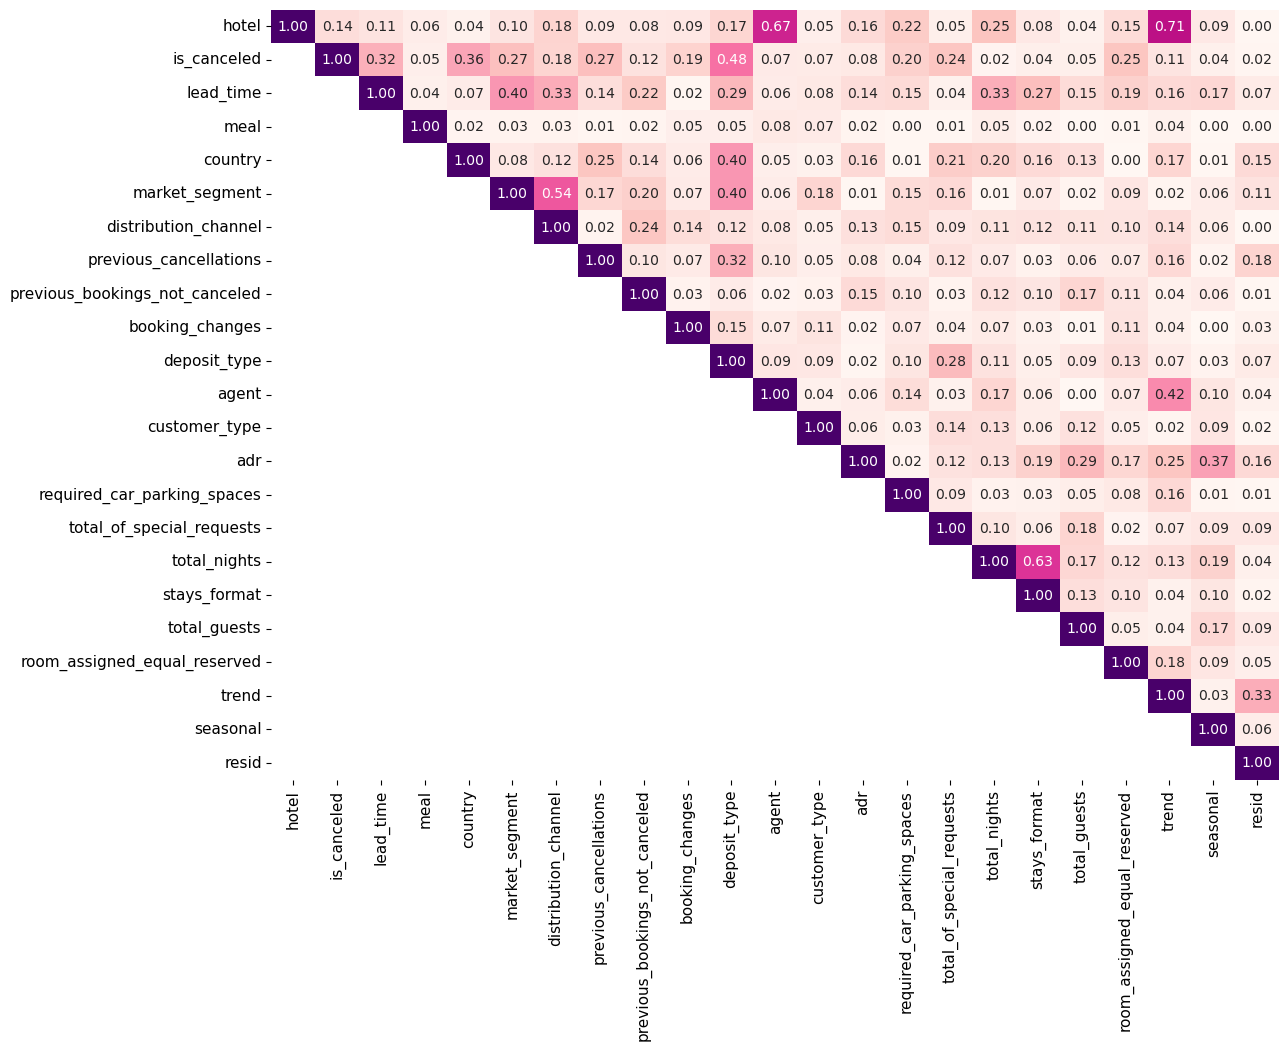

In [131]:
plt.figure(figsize = (13,10))
sns.heatmap(upper_triangle, cbar=False, cmap = 'RdPu', annot=True, fmt='.2f')
plt.show()

#### no highly correlated features detected

#### let us renew our lists of columns

In [132]:
cols_to_drop_later = []
for col in drop_candidates:
    if col in added_cols and col not in forming_cols:
        added_cols.remove(col)
        continue
    if col not in forming_cols:
        cols_to_drop.append(col)
    else:
        cols_to_drop_later.append(col)

In [133]:
print(added_cols)

['total_nights', 'stays_format', 'total_guests', 'room_assigned_equal_reserved', 'deposit_type', 'trend', 'seasonal', 'resid']


In [134]:
print(cols_to_drop)

['company', 'reservation_status', 'arrival_date_week_number', 'arrival_date_day_of_month', 'reservation_status_date', 'is_repeated_guest', 'days_in_waiting_list']


In [135]:
print(cols_to_drop_later)

['stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'babies', 'assigned_room_type', 'reserved_room_type', 'arrival_date_year', 'arrival_date_month']


<a id='etl_pipe'></a>

# Performing ETL-Pipeline

In [1]:
import pandas as pd
import numpy as np
import warnings

warnings.filterwarnings('ignore')
pd.options.display.max_columns = 100

In [2]:
added_cols = ['total_nights', 'stays_format', 'total_guests', 'room_assigned_equal_reserved', 'deposit_type', 
              'trend', 'seasonal', 'resid']

In [3]:
cols_to_drop = ['company', 'reservation_status', 'arrival_date_week_number', 
                'arrival_date_day_of_month', 'reservation_status_date', 'is_repeated_guest', 
                'days_in_waiting_list', 'is_canceled']

In [4]:
cols_to_drop_later = ['stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'babies', 
                      'assigned_room_type', 'reserved_room_type', 'arrival_date_year', 'arrival_date_month']

In [5]:
# Extracting data
raw_data = pd.read_csv('hotel_bookings.csv').query("adults>0")

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn import set_config

In [7]:
set_config(transform_output='pandas')

In [8]:
X = raw_data.drop(cols_to_drop, axis = 1)
y = raw_data['is_canceled']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123, stratify=y)

In [10]:
len(X_train)

83290

In [11]:
len(X_train.columns)

24

### Transforming data

In [12]:
children_imputer = SimpleImputer(strategy='constant', fill_value=0)

In [13]:
def RandomImpute(df):
    for feature in df:
        random_sample = df[feature].dropna().sample(df[feature].isna().sum())
        random_sample.index = df[df[feature].isna()].index
        df.loc[df[feature].isna(), feature] = random_sample
    return df

In [14]:
imputer = ColumnTransformer(
    transformers=[
        ('children_imputer', children_imputer, ['children']),
        ('rand_imputer', FunctionTransformer(RandomImpute), ['country', 'agent'])
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
)

In [15]:
pipe = Pipeline(
    steps=[
        ('imputer', imputer)
    ])

In [16]:
tmp_X = pipe.fit_transform(X_train)

In [17]:
tmp_X.dtypes.value_counts()

int64      11
object     10
float64     3
Name: count, dtype: int64

In [18]:
tmp_X.isna().sum().sum()

0

#### so far we realized cleaning of dataset and making changes in dtypes through our pipeline

#### let us add all needed features

In [19]:
added_cols

['total_nights',
 'stays_format',
 'total_guests',
 'room_assigned_equal_reserved',
 'deposit_type',
 'trend',
 'seasonal',
 'resid']

In [20]:
from sklearn.base import BaseEstimator, TransformerMixin
# inheritence from these two classes (common convention)

In [21]:
class Create_Stays_Features(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.feature1 = 'stays_in_weekend_nights'
        self.feature2 = 'stays_in_week_nights'
        
    def stays_func(self, row):
        if (row[self.feature1] > 0)&(row[self.feature2] == 0):
            return 'just_weekend'
        if (row[self.feature1] == 0)&(row[self.feature2] > 0):
            return 'just_week'
        if (row[self.feature1] > 0)&(row[self.feature2] > 0):
            return 'both_weekend_and_week'
        else:
            return 'undefined'
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X['total_nights'] = X[self.feature1] + X[self.feature2]
        X['stays_format'] = X.apply(self.stays_func, axis=1)
        return X

In [22]:
def create_guests_feat(df):
    df['total_guests'] = df['adults'] + df['children'] + df['babies']
    return df

In [23]:
class Create_Room_Feature(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.feature1 = 'assigned_room_type'
        self.feature2 = 'reserved_room_type'
        
    def room_type(self, row):
        if row[self.feature1] == row[self.feature2]:
            return 1
        else:
            return 0
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X['room_assigned_equal_reserved'] = X.apply(self.room_type, axis = 1)
        return X

In [24]:
class Transform_Deposit_Feature(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.feat = 'deposit_type'
        
    def change_type(self, row):
        if row[self.feat] == 'Non Refund':
            return 1
        else:
            return 0
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X[self.feat] = X.apply(self.change_type, axis=1)
        return X

In [25]:
class Add_Seasonal_components(BaseEstimator, TransformerMixin):
    def __init__(self, time_cols, group_cols, agg_col):
        self.time_cols = time_cols
        self.group_cols = group_cols
        self.agg_col = agg_col
        
    def get_seasonal(self, group, time_cols, agg_col, period):
        from statsmodels.tsa.seasonal import seasonal_decompose
        group = group.reset_index()
        ts = group.groupby(time_cols)[agg_col].median()

        # Handle groups with insufficient data
        if len(ts) < period+1:
            return group.assign(seasonal=0, trend=0, resid=0).set_index('index')

        # Decompose the time series
        res = seasonal_decompose(ts, model='additive', period=period, extrapolate_trend='freq')
    
        # Attaching decomposed components to the ts
        components = (pd.DataFrame(ts).assign(trend = res.trend.values,
                                        seasonal = res.seasonal.values,
                                        resid = res.resid.values)
                                        .drop([agg_col], axis=1).reset_index())
    
        # merging group and components on time_col
        return pd.merge(group, components, on=time_cols).set_index('index')
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return (X.groupby(self.group_cols)
                .apply(self.get_seasonal, time_cols=self.time_cols, agg_col=self.agg_col, period=12)
                .drop(columns=self.group_cols)
                .reset_index(drop=False)
                .set_index('index')
                .loc[X.index]
               )

In [26]:
def drop_last_cols(df):
    cols_to_drop_later = ['stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'babies', 
                      'assigned_room_type', 'reserved_room_type', 'arrival_date_year', 'arrival_date_month']
    return df.drop(cols_to_drop_later, axis=1)

In [27]:
feat_generator = ColumnTransformer(
    transformers=[
        ('stays_feats', Create_Stays_Features(), ['stays_in_weekend_nights', 'stays_in_week_nights']),
        ('guests_feat', FunctionTransformer(create_guests_feat), ['adults', 'children', 'babies']),
        ('room_feat', Create_Room_Feature(), ['assigned_room_type', 'reserved_room_type']),
        ('deposit_feat', Transform_Deposit_Feature(), ['deposit_type'])
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
)

In [30]:
Transform_Pipeline = Pipeline(
    steps=[
        ('imputer', imputer),
        ('feat_generator', feat_generator),
        ('add_seasonal_components', Add_Seasonal_components(
            time_cols=['arrival_date_year', 'arrival_date_month'], group_cols='hotel', agg_col='adr')),
        ('drop_feats', FunctionTransformer(drop_last_cols))
    ])

#### In spite of the model type we are going to implement further we will be loading data which is obtained as a result of above tranformations:

In [29]:
Transform_Pipeline.fit_transform(X_train, y_train)

,hotel,total_nights,stays_format,total_guests,room_assigned_equal_reserved,deposit_type,country,agent,lead_time,meal,market_segment,distribution_channel,previous_cancellations,previous_bookings_not_canceled,booking_changes,customer_type,adr,required_car_parking_spaces,total_of_special_requests,trend,seasonal,resid
101347,City Hotel,1,just_week,2.0,1,0,ITA,9.0,119,SC,Online TA,TA/TO,0,0,0,Transient,161.10,0,1,100.835417,-11.057355,-0.778062
16480,Resort Hotel,4,just_week,2.0,1,0,ESP,240.0,37,BB,Online TA,TA/TO,0,0,0,Transient,153.00,0,2,80.966564,12.992470,60.040966
16203,Resort Hotel,14,both_weekend_and_week,2.0,1,0,IRL,95.0,127,BB,Offline TA/TO,TA/TO,0,0,0,Transient,119.25,0,0,80.966564,12.992470,60.040966
118135,City Hotel,3,both_weekend_and_week,2.0,0,0,IRL,9.0,23,BB,Online TA,TA/TO,0,0,0,Transient,190.00,0,0,106.049583,25.895662,-1.445245
113037,City Hotel,2,just_week,1.0,1,0,BEL,9.0,6,BB,Aviation,Corporate,0,0,0,Transient,110.00,0,0,115.724298,-1.352604,14.828306
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87946,City Hotel,4,both_weekend_and_week,2.0,1,0,DEU,9.0,81,BB,Online TA,TA/TO,0,0,0,Transient,103.70,0,1,87.466667,10.270870,-1.437537
73268,City Hotel,7,both_weekend_and_week,3.0,1,0,ROU,9.0,177,BB,Online TA,TA/TO,0,0,0,Transient,164.44,0,0,106.049583,25.895662,-1.445245
37567,Resort Hotel,4,both_weekend_and_week,2.0,1,0,ESP,240.0,131,BB,Online TA,TA/TO,0,0,0,Transient,154.00,1,1,92.183300,43.726755,-25.910055
41091,City Hotel,2,just_week,2.0,1,0,PRT,1.0,41,BB,Groups,TA/TO,0,0,0,Transient-Party,62.00,0,0,79.732108,-5.207678,0.475571


#### let us save our transform pipeline

In [31]:
import dill as pickle
with open('Transform_pipe.pkl', 'wb') as file:
    pickle.dump(Transform_Pipeline, file)

<a id='model_building'><a/>

# Model Building

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import set_config

import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = 100
set_config(transform_output='pandas')

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, TargetEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression

In [3]:
# setting runtime configurtion
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 13
plt.rcParams['xtick.labelsize'] = 11
plt.rcParams['ytick.labelsize'] = 11

In [4]:
raw_data = pd.read_csv('hotel_bookings.csv').query("adults>0")

In [5]:
cols_to_drop = ['company', 'reservation_status', 'arrival_date_week_number', 
                'arrival_date_day_of_month', 'reservation_status_date', 'is_repeated_guest', 
                'days_in_waiting_list', 'is_canceled']

In [6]:
X = raw_data.drop(cols_to_drop, axis = 1)
y = raw_data['is_canceled']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123, stratify=y)

In [8]:
import dill as pickle
with open('Transform_pipe.pkl', 'rb') as file:
    Transform_Pipe = pickle.load(file)

In [9]:
def debug_transformer(X, name):
    globals()[name] = X
    return X

### [LogisticRegression](#log_reg)

<a id = 'log_reg'><a/>

### LogisticRegression

##### Encoding

In [10]:
X_train_transformed = Transform_Pipe.fit_transform(X_train, y_train)

In [11]:
X_train_transformed.dtypes.value_counts()

int64      9
object     7
float64    6
Name: count, dtype: int64

In [12]:
cat_feats_df = X_train_transformed.select_dtypes('object')

In [13]:
cat_feats_df.nunique()

hotel                     2
stays_format              4
country                 168
meal                      5
market_segment            8
distribution_channel      5
customer_type             4
dtype: int64

In [14]:
high_cardinality_feats = ['country']
low_cardinality_feats = cat_feats_df.columns.difference(high_cardinality_feats)

In [15]:
X_train_transformed[low_cardinality_feats].head()

,customer_type,distribution_channel,hotel,market_segment,meal,stays_format
67035,Transient,TA/TO,City Hotel,Offline TA/TO,BB,both_weekend_and_week
4160,Transient,TA/TO,Resort Hotel,Online TA,BB,both_weekend_and_week
93116,Transient,TA/TO,City Hotel,Online TA,SC,just_week
34164,Transient-Party,TA/TO,Resort Hotel,Groups,BB,both_weekend_and_week
93018,Transient,TA/TO,City Hotel,Online TA,BB,just_week


#### As we observe low cardinality features are nominal with no sign of ordinality in them. We will apply one-hot encoding to exclude any dependency among categories in such features. We will apply target encoding to the rest to avoid curse of dimensionality.

In [16]:
one_hot_encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
target_encoder = TargetEncoder(target_type='binary', random_state=142)

In [17]:
preprocessor = ColumnTransformer(
    transformers=[
        ('one_hot_encoder', one_hot_encoder, low_cardinality_feats),
        ('target_encoder', target_encoder, high_cardinality_feats)
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
)

In [18]:
log_reg1 = Pipeline(
    steps=[
        ('Transform_pipeline', Transform_Pipe),
        ('preprocessor', preprocessor),
        # in this step we can obtain the result of transform by ETL_pipeline and preprocessor 
        ('debug', FunctionTransformer(debug_transformer, kw_args={'name': 'tmp_X'})),
        ('model', LogisticRegression())
    ])

In [19]:
log_reg1.fit(X_train, y_train)

Pipeline(steps=[('Transform_pipeline',
                 Pipeline(steps=[('imputer',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('children_imputer',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant'),
                                                                   ['children']),
                                                                  ('rand_imputer',
                                                                   FunctionTransformer(func=<function RandomImpute at 0x14d0fd6c0>),
                                                                   ['country',
                                                                    'agent'])],
                                                    verbose_feature_names_out=False)),
                                 ('feat_genera...
                                                  Index(['customer_type', 'distribution_channel', 'hotel', 'market_segment',
       'meal', 'stays_format'],
      dtype='object')),
                                                 ('target_encoder',
                                                  TargetEncoder(random_state=142,
                                                                target_type='binary'),
                                                  ['country'])],
                                   verbose_feature_names_out=False)),
                ('debug',
                 FunctionTransformer(func=<function debug_transformer at 0x14d360a40>,
                                     kw_args={'name': 'tmp_X'})),
                ('model', LogisticRegression())])

In [20]:
tmp_X

,customer_type_Group,customer_type_Transient,customer_type_Transient-Party,distribution_channel_Direct,distribution_channel_GDS,distribution_channel_TA/TO,distribution_channel_Undefined,hotel_Resort Hotel,market_segment_Complementary,market_segment_Corporate,market_segment_Direct,market_segment_Groups,market_segment_Offline TA/TO,market_segment_Online TA,market_segment_Undefined,meal_FB,meal_HB,meal_SC,meal_Undefined,stays_format_just_week,stays_format_just_weekend,stays_format_undefined,country,total_nights,total_guests,room_assigned_equal_reserved,deposit_type,agent,lead_time,previous_cancellations,previous_bookings_not_canceled,booking_changes,adr,required_car_parking_spaces,total_of_special_requests,trend,seasonal,resid
67035,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.567466,4,2.0,1,1,31.0,111,0,0,0,120.00,0,0,105.012500,10.190018,-0.202518
4160,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.566169,7,2.0,1,0,240.0,55,0,0,0,58.00,0,0,81.304583,-38.287847,10.983264
93116,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.251796,4,2.0,1,0,8.0,114,0,0,0,89.25,0,0,97.506667,11.740718,-2.147384
34164,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.204467,10,2.0,1,0,273.0,195,0,0,0,64.28,0,0,92.851909,13.183332,-49.250241
93018,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.185121,4,2.0,1,0,9.0,149,0,0,0,99.45,0,1,97.506667,11.740718,-2.147384
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87946,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.165317,4,2.0,1,0,9.0,81,0,0,0,103.70,0,1,87.637917,10.190018,-1.527934
61163,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.359265,21,2.0,1,0,195.0,17,0,0,0,75.66,0,0,91.661875,-13.851295,10.189420
37567,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.257083,4,2.0,1,0,240.0,131,0,0,0,154.00,1,1,92.190949,43.779109,-25.970058
41091,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.566169,2,2.0,1,0,1.0,41,0,0,0,62.00,0,0,80.049057,-5.269124,0.220067


In [21]:
test_score = log_reg1.score(X_test, y_test)

In [22]:
print(f"We created our first model with the accuracy score {test_score:.4f} on the test set")

We created our first model with the accuracy score 0.8030 on the test set


In [23]:
y_train.value_counts()/len(y_train)

is_canceled
0    0.629247
1    0.370753
Name: count, dtype: float64

#### As our classes are not ideally balanced, such metrics as precision, recall and roc_auc would be more insightful to use

In [24]:
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

#### In order for LogisticRegression to perform well, its' assumptions should be taken into consideration. More specifically, we have to deal with outliers in data, as they may affect our model's perfomance.

In [25]:
num_cols = X_train_transformed.select_dtypes(exclude='object').columns
len(num_cols)

15

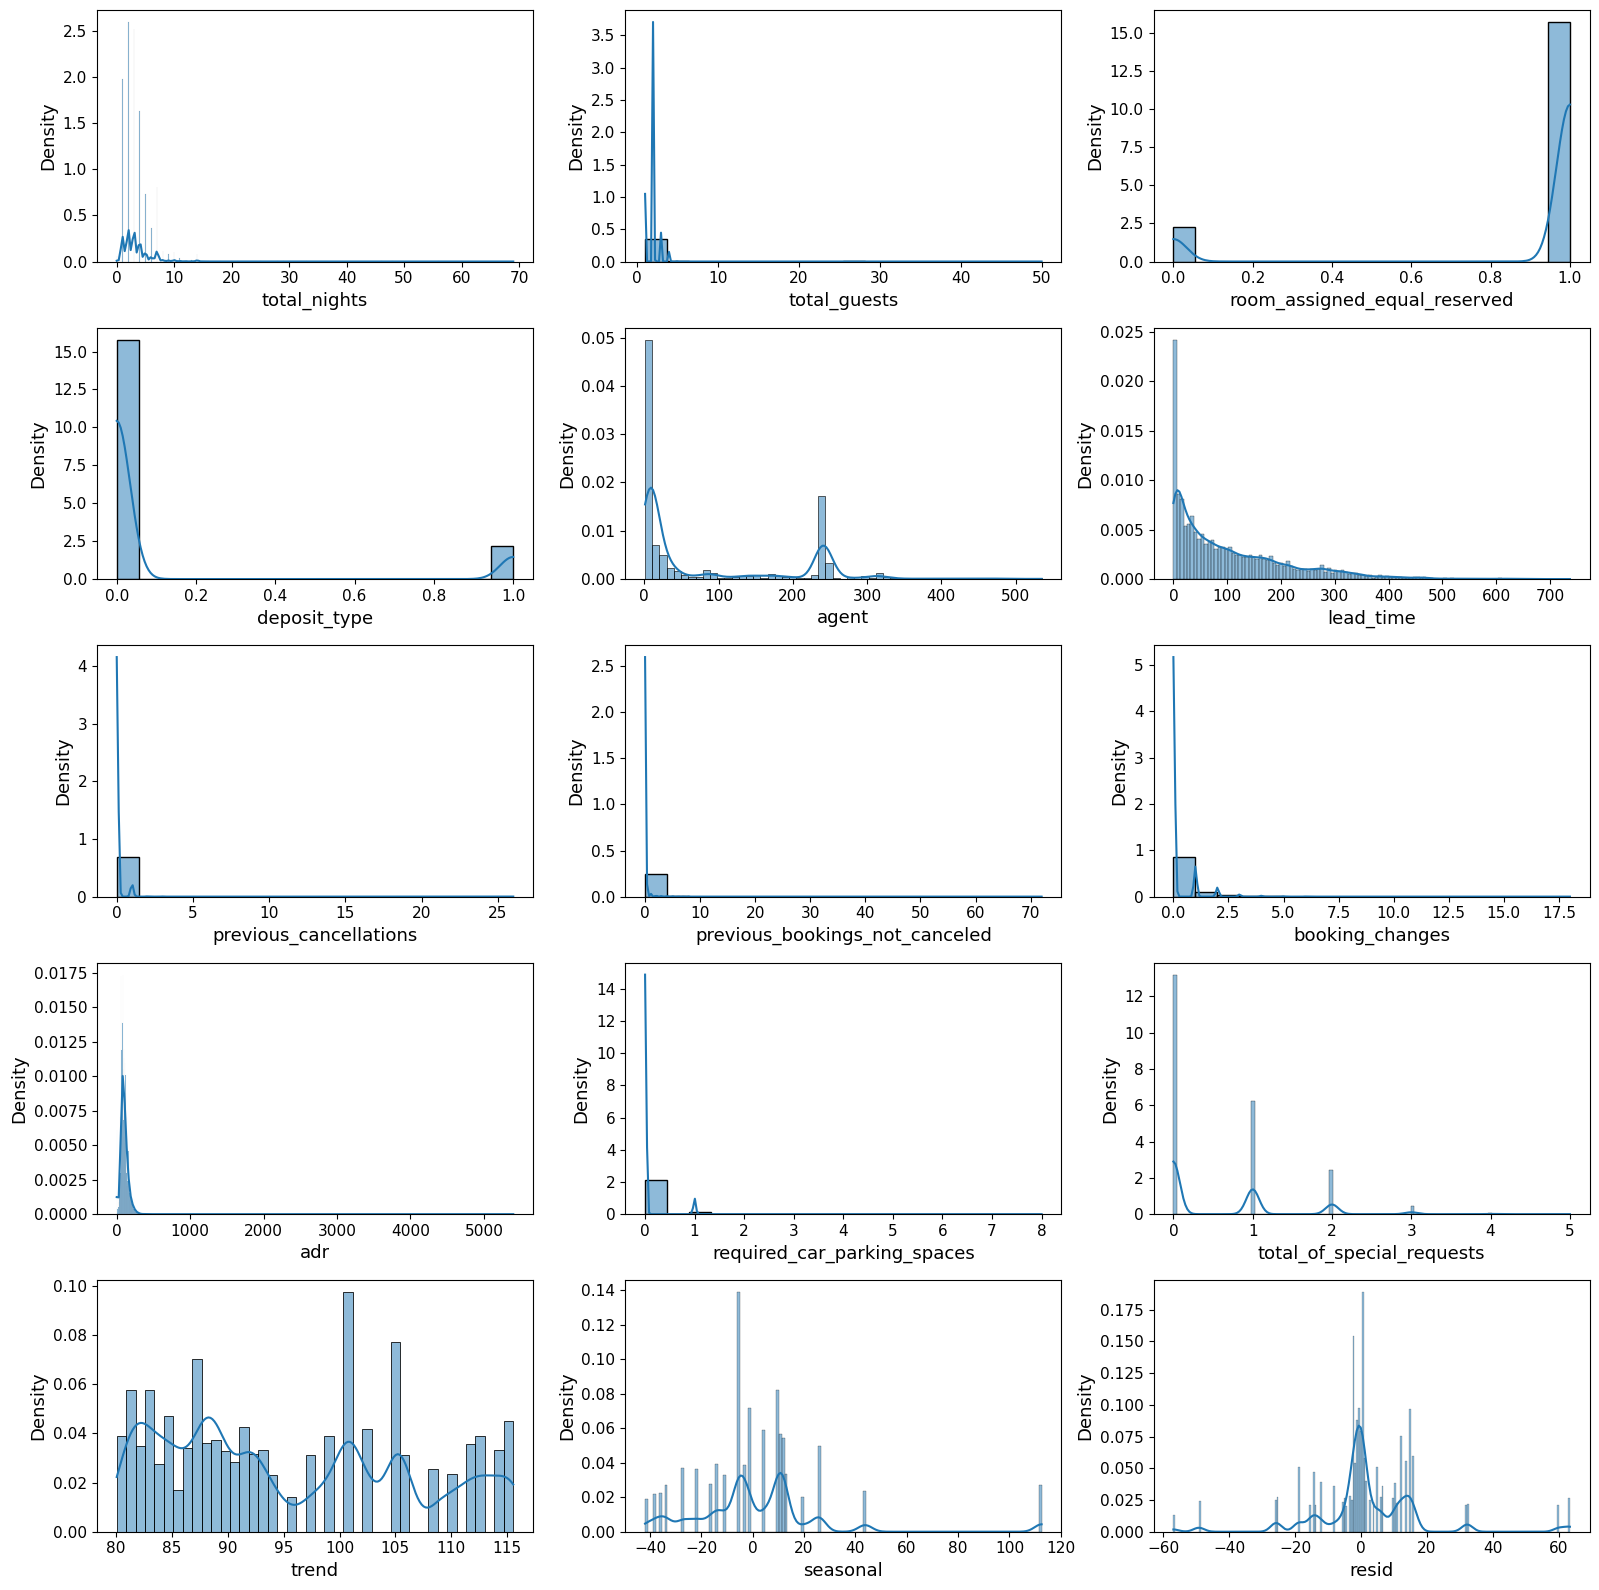

In [26]:
fig, ax = plt.subplots(5,3, figsize = (16,16))

for i, col in enumerate(num_cols):
    sns.histplot(data = X_train_transformed, x = col, ax = ax[i//3, i%3], stat='density', kde=True)

fig.tight_layout()

#### We will approach this problem as before, but encapsulating everything into functions

In [27]:
outlier_columns = ['total_guests', 'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes',
                  'required_car_parking_spaces', 'total_of_special_requests', 'total_nights']
values = [4, 1, 1, 1, 1, 2, 8]

d = {}

for obj in zip(outlier_columns, values):
    d[obj[0]] = obj[1]

print(d)    

{'total_guests': 4, 'previous_cancellations': 1, 'previous_bookings_not_canceled': 1, 'booking_changes': 1, 'required_car_parking_spaces': 1, 'total_of_special_requests': 2, 'total_nights': 8}


In [28]:
def outlier_func(df):
    dictionary = {'total_guests': 4, 'previous_cancellations': 1, 'previous_bookings_not_canceled': 1, 
                  'booking_changes': 1, 'required_car_parking_spaces': 1, 'total_of_special_requests': 2, 
                  'total_nights': 8}
    for col in df:
        val = dictionary[col]
        df[col] = np.where(df[col]>=val, val, df[col])
    return df

In [29]:
def log_transform(df):
    for col in df:
        df[col] = np.log1p(df[col])
    return df.fillna(0) 

In [30]:
# binning feature agent
binner = KBinsDiscretizer(n_bins=6, encode='ordinal', strategy='quantile', random_state=134)

In [31]:
preprocessor = ColumnTransformer(
    transformers=[
        ('one_hot_encoder', one_hot_encoder, low_cardinality_feats),
        ('target_encoder', target_encoder, high_cardinality_feats),
        ('outliers_replace', FunctionTransformer(outlier_func), outlier_columns),
        ('log_transform', FunctionTransformer(log_transform), ['lead_time', 'adr']),
        ('binning', binner, ['agent'])
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
)

In [32]:
X_train_preprocessed = preprocessor.fit_transform(X_train_transformed, y_train)

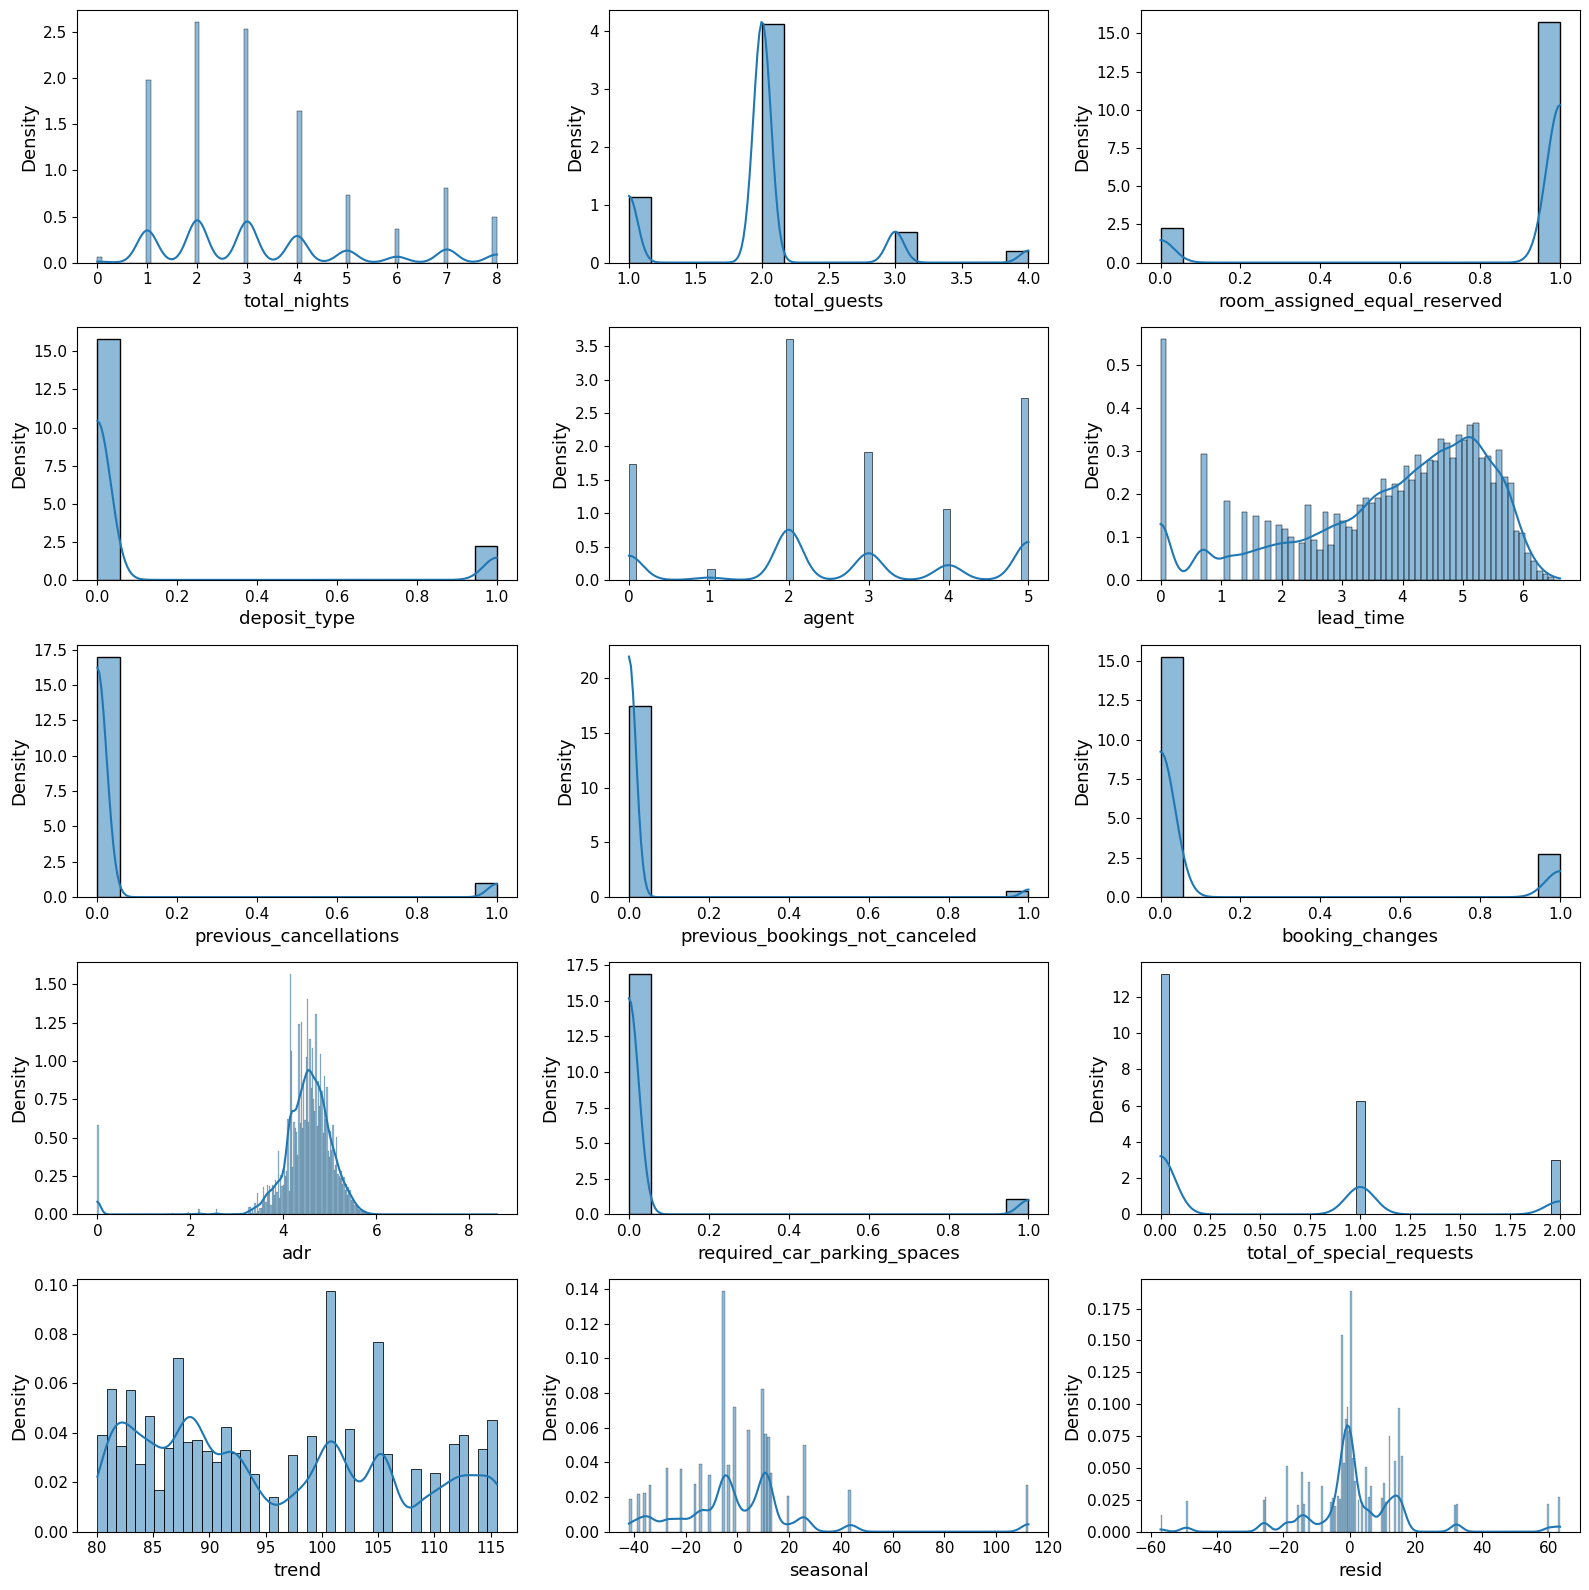

In [33]:
fig, ax = plt.subplots(5,3, figsize = (16,16))

for i, col in enumerate(num_cols):
    sns.histplot(data = X_train_preprocessed, x = col, ax = ax[i//3, i%3], stat='density', kde=True)

fig.tight_layout()

#### As LogisticRegression uses gradient descent to optimize feature weights, bringing the data to the similar scale would be neccessary

In [34]:
std_scaler = StandardScaler()
min_max_scaler = MinMaxScaler()

In [35]:
scaler = ColumnTransformer(
    transformers=[
        ('std_scaler', std_scaler, ['lead_time', 'adr', 'seasonal', 'resid']),
        ('min_max_scaler', min_max_scaler, ['total_nights', 'total_guests', 
                                            'agent', 'total_of_special_requests', 'trend'])
    ],
    remainder = 'passthrough'
)

In [36]:
log_reg2 = Pipeline(
    steps=[
        ('Transform_pipeline', Transform_Pipe),
        ('preprocessor', preprocessor),
        ('scaler', scaler),
        ('debug', FunctionTransformer(debug_transformer, kw_args={'name': 'tmp_X'})),
        ('model', LogisticRegression())
    ])

#### So, we created a specific model building procedure which consists of different steps (transforming, preprocessing, scaling...). It is time to estimate its' generalization perfomance and for that purpose we will resort to NestedCrossValidation. This is a computationally expensive technique, however our dataset is not too big so we'll go for it. The key advantage of Nested CV is that it prevents information leakage during the training procedure leading to not overly optimistic results on the validation data.

In [37]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

In [38]:
outer_cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=123)
inner_cv = StratifiedKFold(n_splits=3)

In [39]:
l1 = np.array([0.1, 0.3, 0.5, 0.7, 1])
l2 = np.arange(5, 31, 5)
l3 = np.arange(40, 151, 10)
C_list = np.concatenate([l1,l2,l3])

In [40]:
param_grid = {'model__C': C_list}

In [41]:
model = GridSearchCV(log_reg2, param_grid=param_grid, cv = inner_cv, n_jobs=-1, scoring='f1')

In [42]:
from time import time

In [43]:
t0 = time()
cv_scores = cross_validate(model, X, y, cv = outer_cv, n_jobs=-1, 
                           scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],
                           return_train_score=True)

/var/folders/_r/r8qlh4793lq2d10fd5xwfmwh0000gn/T/ipykernel_10074/2737576348.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
/var/folders/_r/r8qlh4793lq2d10fd5xwfmwh0000gn/T/ipykernel_10074/2737576348.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
/var/folders/_r/r8qlh4793lq2d10fd5xwfmwh0000gn/T/ipykernel_10074/2737576348.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping colum

/var/folders/_r/r8qlh4793lq2d10fd5xwfmwh0000gn/T/ipykernel_10074/2737576348.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
/var/folders/_r/r8qlh4793lq2d10fd5xwfmwh0000gn/T/ipykernel_10074/2737576348.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
/var/folders/_r/r8qlh4793lq2d10fd5xwfmwh0000gn/T/ipykernel_10074/2737576348.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping colum

/Users/evgeniikuryzhov/Documents/Anaconda/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/Users/evgeniikuryzhov/Documents/Anaconda/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/Users/evgeniikuryzhov/Documents/Anaconda/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/evgeniikuryzhov/Documents/Anaconda/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number o

/var/folders/_r/r8qlh4793lq2d10fd5xwfmwh0000gn/T/ipykernel_10074/2737576348.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
/var/folders/_r/r8qlh4793lq2d10fd5xwfmwh0000gn/T/ipykernel_10074/2737576348.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
/var/folders/_r/r8qlh4793lq2d10fd5xwfmwh0000gn/T/ipykernel_10074/2737576348.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping colum

/Users/evgeniikuryzhov/Documents/Anaconda/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [1, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/evgeniikuryzhov/Documents/Anaconda/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [1, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/var/folders/_r/r8qlh4793lq2d10fd5xwfmwh0000gn/T/ipykernel_10074/2737576348.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
/Users/evgeniikuryzhov/Documents/Anaconda/anac

/var/folders/_r/r8qlh4793lq2d10fd5xwfmwh0000gn/T/ipykernel_10074/2737576348.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
/var/folders/_r/r8qlh4793lq2d10fd5xwfmwh0000gn/T/ipykernel_10074/2737576348.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
/var/folders/_r/r8qlh4793lq2d10fd5xwfmwh0000gn/T/ipykernel_10074/2737576348.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping colum

/var/folders/_r/r8qlh4793lq2d10fd5xwfmwh0000gn/T/ipykernel_10074/2737576348.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
/var/folders/_r/r8qlh4793lq2d10fd5xwfmwh0000gn/T/ipykernel_10074/2737576348.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
/Users/evgeniikuryzhov/Documents/Anaconda/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:307: UserWarning: Bins whose width

/Users/evgeniikuryzhov/Documents/Anaconda/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/evgeniikuryzhov/Documents/Anaconda/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/Users/evgeniikuryzhov/Documents/Anaconda/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/evgeniikuryzhov/Documents/Anaconda/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/Users/evgeniikuryzhov/Documen

/var/folders/_r/r8qlh4793lq2d10fd5xwfmwh0000gn/T/ipykernel_10074/2737576348.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
/var/folders/_r/r8qlh4793lq2d10fd5xwfmwh0000gn/T/ipykernel_10074/2737576348.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
/var/folders/_r/r8qlh4793lq2d10fd5xwfmwh0000gn/T/ipykernel_10074/2737576348.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping colum

/Users/evgeniikuryzhov/Documents/Anaconda/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/evgeniikuryzhov/Documents/Anaconda/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [1, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/evgeniikuryzhov/Documents/Anaconda/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/var/folders/_r/r8qlh4793lq2d10fd5xwfmwh0000gn/T/ipykernel_10074/2737576348.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future ver

/var/folders/_r/r8qlh4793lq2d10fd5xwfmwh0000gn/T/ipykernel_10074/2737576348.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
/var/folders/_r/r8qlh4793lq2d10fd5xwfmwh0000gn/T/ipykernel_10074/2737576348.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
/var/folders/_r/r8qlh4793lq2d10fd5xwfmwh0000gn/T/ipykernel_10074/2737576348.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping colum

/var/folders/_r/r8qlh4793lq2d10fd5xwfmwh0000gn/T/ipykernel_10074/2737576348.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
/var/folders/_r/r8qlh4793lq2d10fd5xwfmwh0000gn/T/ipykernel_10074/2737576348.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
/var/folders/_r/r8qlh4793lq2d10fd5xwfmwh0000gn/T/ipykernel_10074/2737576348.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping colum

/Users/evgeniikuryzhov/Documents/Anaconda/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/evgeniikuryzhov/Documents/Anaconda/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/Users/evgeniikuryzhov/Documents/Anaconda/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/evgeniikuryzhov/Documents/Anaconda/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/var/folders/_r/r8qlh4793lq2d1

/Users/evgeniikuryzhov/Documents/Anaconda/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/var/folders/_r/r8qlh4793lq2d10fd5xwfmwh0000gn/T/ipykernel_10074/2737576348.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
/Users/evgeniikuryzhov/Doc

/var/folders/_r/r8qlh4793lq2d10fd5xwfmwh0000gn/T/ipykernel_10074/2737576348.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
/var/folders/_r/r8qlh4793lq2d10fd5xwfmwh0000gn/T/ipykernel_10074/2737576348.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
/Users/evgeniikuryzhov/Documents/Anaconda/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categori

/Users/evgeniikuryzhov/Documents/Anaconda/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/_r/r8qlh4793lq2d10fd5xwfmwh0000gn/T/ipykernel_10074/2737576348.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
/var/folders/_r/r8qlh4793lq2d10fd5xwfmwh0000gn/T/ipykernel_10074/2737576348.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select t

/var/folders/_r/r8qlh4793lq2d10fd5xwfmwh0000gn/T/ipykernel_10074/2737576348.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
/var/folders/_r/r8qlh4793lq2d10fd5xwfmwh0000gn/T/ipykernel_10074/2737576348.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
/Users/evgeniikuryzhov/Documents/Anaconda/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:307: UserWarning: Bins whose width

/Users/evgeniikuryzhov/Documents/Anaconda/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/Users/evgeniikuryzhov/Documents/Anaconda/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/Users/evgeniikuryzhov/Documents/Anaconda/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/var/folders/_r/r8qlh4793lq2d10fd5xwfmwh0000gn/T/ipykernel_10074/2737576348.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, a

/Users/evgeniikuryzhov/Documents/Anaconda/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/evgeniikuryzhov/Documents/Anaconda/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sci

/var/folders/_r/r8qlh4793lq2d10fd5xwfmwh0000gn/T/ipykernel_10074/2737576348.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
/var/folders/_r/r8qlh4793lq2d10fd5xwfmwh0000gn/T/ipykernel_10074/2737576348.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
/Users/evgeniikuryzhov/Documents/Anaconda/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categori

/Users/evgeniikuryzhov/Documents/Anaconda/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/var/folders/_r/r8qlh4793lq2d10fd5xwfmwh0000gn/T/ipykernel_10074/2737576348.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
/Users/evgeniikuryzhov/Documents/Anaconda/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/evgeniikuryzhov/Documents/Anaconda/anaconda3/lib/python3.11/site-packages/pandas/core/arrayli

/var/folders/_r/r8qlh4793lq2d10fd5xwfmwh0000gn/T/ipykernel_10074/2737576348.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
/var/folders/_r/r8qlh4793lq2d10fd5xwfmwh0000gn/T/ipykernel_10074/2737576348.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
/var/folders/_r/r8qlh4793lq2d10fd5xwfmwh0000gn/T/ipykernel_10074/2737576348.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping colum

/var/folders/_r/r8qlh4793lq2d10fd5xwfmwh0000gn/T/ipykernel_10074/2737576348.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
/var/folders/_r/r8qlh4793lq2d10fd5xwfmwh0000gn/T/ipykernel_10074/2737576348.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
/Users/evgeniikuryzhov/Documents/Anaconda/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in 

/Users/evgeniikuryzhov/Documents/Anaconda/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/var/folders/_r/r8qlh4793lq2d10fd5xwfmwh0000gn/T/ipykernel_10074/2737576348.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
/Users/evgeniikuryzhov/Documents/Anaconda/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/Users/evgeniikuryzhov/Documents/Anaco

/Users/evgeniikuryzhov/Documents/Anaconda/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/var/folders/_r/r8qlh4793lq2d10fd5xwfmwh0000gn/T/ipykernel_10074/2737576348.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
/var/folders/_r/r8qlh4793l

/Users/evgeniikuryzhov/Documents/Anaconda/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/var/folders/_r/r8qlh4793lq2d10fd5xwfmwh0000gn/T/ipykernel_10074/2737576348.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
/var/folders/_r/r8qlh4793lq2d10fd5xwfmwh0000gn/T/ipykernel_10074/2737576348.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False`

/Users/evgeniikuryzhov/Documents/Anaconda/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [1, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/evgeniikuryzhov/Documents/Anaconda/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [1, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/evgeniikuryzhov/Documents/Anaconda/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/evgeniikuryzhov/Documents/Anaconda/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/_r/r8qlh4793lq2d10fd5xwfm

/var/folders/_r/r8qlh4793lq2d10fd5xwfmwh0000gn/T/ipykernel_10074/2737576348.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
/Users/evgeniikuryzhov/Documents/Anaconda/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/Users/evgeniikuryzhov/Documents/Anaconda/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/var/folders/_r/r8qlh4793lq2d10fd5xwfm

/Users/evgeniikuryzhov/Documents/Anaconda/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/evgeniikuryzhov/Documents/Anaconda/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/Users/evgeniikuryzhov/Documents/Anaconda/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/evgeniikuryzhov/Documents/Anaconda/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/Users/evgeniikuryzhov/Documen

/Users/evgeniikuryzhov/Documents/Anaconda/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/evgeniikuryzhov/Documents/Anaconda/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/Users/evgeniikuryzhov/Documents/Anaconda/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


/var/folders/_r/r8qlh4793lq2d10fd5xwfmwh0000gn/T/ipykernel_10074/2737576348.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
/Users/evgeniikuryzhov/Documents/Anaconda/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/var/folders/_r/r8qlh4793l

/var/folders/_r/r8qlh4793lq2d10fd5xwfmwh0000gn/T/ipykernel_10074/2737576348.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
/Users/evgeniikuryzhov/Documents/Anaconda/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [1, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/var/folders/_r/r8qlh4793lq2d10fd5xwfmwh0000gn/T/ipykernel_10074/2737576348.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=Fal

/var/folders/_r/r8qlh4793lq2d10fd5xwfmwh0000gn/T/ipykernel_10074/2737576348.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
/var/folders/_r/r8qlh4793lq2d10fd5xwfmwh0000gn/T/ipykernel_10074/2737576348.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
/var/folders/_r/r8qlh4793lq2d10fd5xwfmwh0000gn/T/ipykernel_10074/2737576348.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping colum

/var/folders/_r/r8qlh4793lq2d10fd5xwfmwh0000gn/T/ipykernel_10074/2737576348.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
/Users/evgeniikuryzhov/Documents/Anaconda/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/var/folders/_r/r8qlh4793lq2d10fd5xwfmwh0000gn/T/ipykernel_10074/2737576348.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups

/Users/evgeniikuryzhov/Documents/Anaconda/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/Users/evgeniikuryzhov/Documents/Anaconda/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/evgeniikuryzhov/Documents/Anaconda/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/Users/evgeniikuryzhov/Documents/Anaconda/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number o

/var/folders/_r/r8qlh4793lq2d10fd5xwfmwh0000gn/T/ipykernel_10074/2737576348.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
/Users/evgeniikuryzhov/Documents/Anaconda/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/evgeniikuryzhov/Doc

/Users/evgeniikuryzhov/Documents/Anaconda/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/var/folders/_r/r8qlh4793lq2d10fd5xwfmwh0000gn/T/ipykernel_10074/2737576348.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
/var/folders/_r/r8qlh4793l

/var/folders/_r/r8qlh4793lq2d10fd5xwfmwh0000gn/T/ipykernel_10074/2737576348.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
/var/folders/_r/r8qlh4793lq2d10fd5xwfmwh0000gn/T/ipykernel_10074/2737576348.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
/var/folders/_r/r8qlh4793lq2d10fd5xwfmwh0000gn/T/ipykernel_10074/2737576348.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping colum

/var/folders/_r/r8qlh4793lq2d10fd5xwfmwh0000gn/T/ipykernel_10074/2737576348.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
/var/folders/_r/r8qlh4793lq2d10fd5xwfmwh0000gn/T/ipykernel_10074/2737576348.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
/Users/evgeniikuryzhov/Documents/Anaconda/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in 

/Users/evgeniikuryzhov/Documents/Anaconda/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/var/folders/_r/r8qlh4793lq2d10fd5xwfmwh0000gn/T/ipykernel_10074/2737576348.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
/Users/evgeniikuryzhov/Documents/Anaconda/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/Users/evgeniikuryzhov/Documents/Anaco

/Users/evgeniikuryzhov/Documents/Anaconda/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/evgeniikuryzhov/Documents/Anaconda/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sci

/Users/evgeniikuryzhov/Documents/Anaconda/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [1, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/evgeniikuryzhov/Documents/Anaconda/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [1, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/var/folders/_r/r8qlh4793lq2d10fd5xwfmwh0000gn/T/ipykernel_10074/2737576348.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
/Users/evgeniikuryzhov/Documents/Anaconda/anac

/var/folders/_r/r8qlh4793lq2d10fd5xwfmwh0000gn/T/ipykernel_10074/2737576348.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
/Users/evgeniikuryzhov/Documents/Anaconda/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/_r/r8qlh4793lq2d10fd5xwfmwh0000gn/T/ipykernel_10074/2737576348.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select t

/var/folders/_r/r8qlh4793lq2d10fd5xwfmwh0000gn/T/ipykernel_10074/2737576348.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
/var/folders/_r/r8qlh4793lq2d10fd5xwfmwh0000gn/T/ipykernel_10074/2737576348.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
/var/folders/_r/r8qlh4793lq2d10fd5xwfmwh0000gn/T/ipykernel_10074/2737576348.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping colum

/var/folders/_r/r8qlh4793lq2d10fd5xwfmwh0000gn/T/ipykernel_10074/2737576348.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
/Users/evgeniikuryzhov/Documents/Anaconda/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/evgeniikuryzhov/Documents/Anaconda/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/evgeniikuryzhov/Documents/Anaconda/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:307: UserWarning: Bins who

/var/folders/_r/r8qlh4793lq2d10fd5xwfmwh0000gn/T/ipykernel_10074/2737576348.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
/Users/evgeniikuryzhov/Documents/Anaconda/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/var/folders/_r/r8qlh4793l

/Users/evgeniikuryzhov/Documents/Anaconda/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [1, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/evgeniikuryzhov/Documents/Anaconda/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/_r/r8qlh4793lq2d10fd5xwfmwh0000gn/T/ipykernel_10074/2737576348.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
/var/folders/_r/r8qlh4793lq2d10fd5xwfmwh0000gn/T/ipykernel_10074/2737576348.py:33: DeprecationWar

/var/folders/_r/r8qlh4793lq2d10fd5xwfmwh0000gn/T/ipykernel_10074/2737576348.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
/Users/evgeniikuryzhov/Documents/Anaconda/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/_r/r8qlh4793lq2d10fd5xwfmwh0000gn/T/ipykernel_10074/2737576348.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select t

In [44]:
print(f"Done in {time() - t0:.1f}s")

Done in 112.3s


In [45]:
cv_table = pd.DataFrame(cv_scores).drop(['fit_time', 'score_time'], axis=1).T

In [46]:
pd.DataFrame({'mean_val': cv_table.mean(axis=1), 'std_val': cv_table.std(axis=1)}, index=cv_table.index)

,mean_val,std_val
test_accuracy,0.831108,0.000486
train_accuracy,0.832281,0.000296
test_precision,0.820608,0.001710
train_precision,0.822421,0.001052
test_recall,0.696793,0.001401
train_recall,0.698440,0.000682
test_f1,0.753647,0.000630
train_f1,0.755376,0.000319
test_roc_auc,0.907794,0.000463
train_roc_auc,0.908681,0.000300
